# 3D Volume-to-Volume Translation with Conditional Adversarial Networks (GAN's)

#### import all necessary libs and frameworks

In [1]:
%matplotlib inline

import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
from skimage.transform import resize
import time

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '../scripts')

import helper as hp
import data_loader3D as dl
import deconvolution as deconv
import pix3pix as p3p

sys.path.insert(0, '../scripts/NanoImagingPack')
from microscopy import PSF3D

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

### look for the data

In [4]:
dataset_name = 'NESb'
# dataset_name = 'dub'

path = glob('../data/3D/{0}/*'.format(dataset_name))
path = [item for item in path if not item.endswith('.txt')]

dl.print_volume_dimension(path, max_print=5)

dimensions of volumes:
0 (9, 1024, 1024)
1 (9, 1024, 1024)
2 (9, 1024, 1024)
3 (9, 1024, 1024)
4 (9, 1024, 1024)


### create TFRecord file

In [7]:
vol_orginal_size = (256, 256, 9)
vol_resize_size = (256, 256, 8)

data_loader = dl.DataLoader3D(simulation=True, 
                              d_name=dataset_name, 
                              manipulation=dl.MANIPULATION.SPATIAL_DOWN, 
                              vol_original=vol_orginal_size,
                              vol_resize=vol_resize_size)

filename = '../data/TFRecords/{0}_train.tfrecords'.format(dataset_name)

# data_loader.writeTFRecord(filename)

### test the 3D psf for a random volume

In [8]:
path = '../data/3D/NESb/NESb_C2_TP1.tiff'

vol = io.imread(path)
vol = hp.swapAxes(vol, swap=True)
vol = data_loader.cut_volume(vol, vol_resize_size, centered=True)

print('image after cut/resize in x/y dimension:', vol.shape)

# compute OTF
start_otf = time.time()
otf = PSF3D(im=vol.shape, ret_val = 'OTF')
end_otf = time.time()

# perform convolution on stack with computed otf (with numpy)
start_conv_np = time.time()
vol_otf = deconv.conv3d_fft(vol, otf)
end_conv_np = time.time()

# perform convolution on stack with computed otf (with tensorflow)
# start_conv_tf = time.time()
# vol_otf_tf = deconv.conv3d_fft_tf(vol, otf)
# end_conv_tf = time.time()

image after cut/resize in x/y dimension: (256, 256, 9)


### add optional noise to presentation volume/image

In [9]:
choice_of_noise = False 

noise_methods = [deconv.flip_vol, deconv.roll_vol, deconv.add_affineTransformation, deconv.add_logIntensityTransformation]
noise_choice = np.random.randint(low=0, high=len(noise_methods), size=1)[0]
noise_choice = noise_methods[noise_choice]

if choice_of_noise:
    vol = noise_choice(vol)
    
    vol_otf = deconv.conv3d_fft(vol, otf)
    vol_otf = noise_choice(vol_otf)
    print('noise method on specified volume:', noise_choice)

In [10]:
# select a random stacks
i = np.random.randint(low=0, high=vol.shape[2], size=1)[0]
print('stack number:\t\t\t', i+1,'/',vol.shape[2])
img = vol[:,:,i]
img_otf = vol_otf[:,:,i]
# img_otf_tf = vol_otf_tf[:,:,i]

print('Time for compute OTF:\t\t', end_otf - start_otf, 's')
print('Time for convolve with numpy:\t', end_conv_np - start_conv_np, 's')
# print('Time for convolve with tensorflow:\t', end_conv_tf - start_conv_tf, 's')

stack number:			 2 / 9
Time for compute OTF:		 0.19624757766723633 s
Time for convolve with numpy:	 0.15311193466186523 s


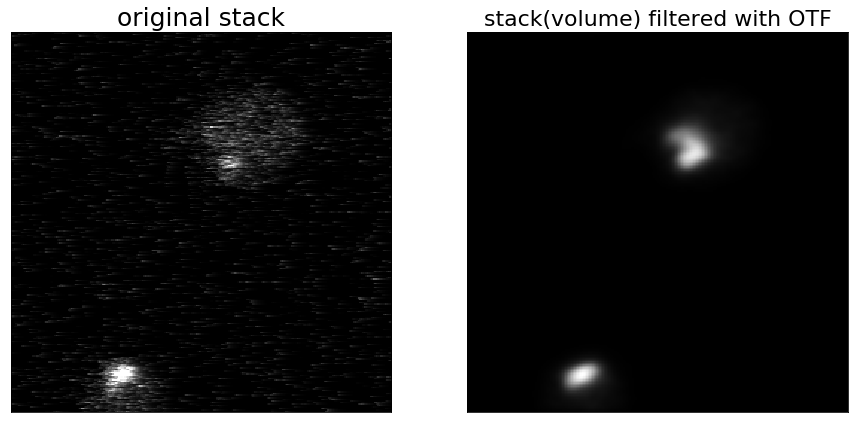

In [11]:
f = plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(img, cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('original stack', fontsize=25)
plt.subplot(122); plt.imshow(img_otf, cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('stack(volume) filtered with OTF', fontsize=22)
# plt.subplot(133); plt.imshow(img_otf_tf, cmap='gray'); plt.xticks([]); plt.yticks([])
plt.show()

### plot entire volume and default PSF 

volume shapes before / after: (256, 256, 9) / (9, 256, 256)
for change the stack use keys: {k,j}


<IPython.core.display.Javascript object>


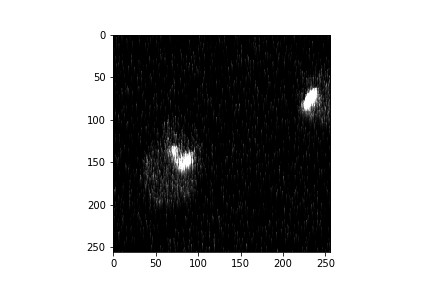

In [60]:
%matplotlib notebook

import plot3DVol as plot3D

vol_3D = plot3D.Interactive_3DVolume(vol=vol)

vol_3D.multi_slice_viewer()

volume shapes before / after: (256, 256, 9) / (9, 256, 256)
for change the stack use keys: {k,j}


<IPython.core.display.Javascript object>


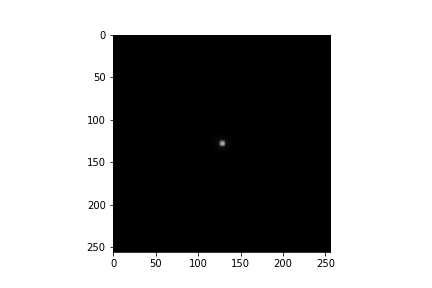

In [28]:
%matplotlib notebook

psf_plot = PSF3D(im=vol.shape, ret_val='PSF')
psf_3D = plot3D.Interactive_3DVolume(vol=psf_plot)
psf_3D.multi_slice_viewer()

In [17]:
%matplotlib inline

### initialize the volume to volume GAN

In [98]:
print('volume orginial size:', vol_orginal_size)
print('volume cut (resize):', vol_resize_size)
print('dataset name:', dataset_name, '\n_________________________________________________________________________')

gan = p3p.Pix3Pix(vol_original=vol_orginal_size,
                  vol_resize=vol_resize_size, 
                  d_name=dataset_name,
                  stack_manipulation=dl.MANIPULATION.SPATIAL_DOWN, 
                  simulation=False,
                  ganhacks=True)
                
                 #.SPATIAL_RESIZE
                 #.SPATIAL_MIN
                 #.SPATIAL_DOWN                  
                 #.SPATIAL_UP
                 #.FREQUENCY_UP
                 #.FREQUENCY_DOWN
                 #.FREQUENCY_MIN

volume orginial size: (256, 256, 9)
volume cut (resize): (256, 256, 8)
dataset name: NESb 
_________________________________________________________________________
mögliche Fehlerquelle bei Berechnung von patch_depth -> self.disc_patch : ...2**3))#4))
discriminator-model in/output:	 (?, 256, 256, 8, 1) (?, 256, 256, 8, 1) 
				 (?, 32, 32, 1, 1)
generator-model input:		 (?, 256, 256, 8, 1)
downsampling:			 (?, 128, 128, 4, 64)
downsampling:			 (?, 64, 64, 2, 128)
downsampling:			 (?, 32, 32, 1, 256)
downsampling:			 (?, 16, 16, 1, 512)
downsampling:			 (?, 8, 8, 1, 512)
upsampling:			 (?, 16, 16, 1, 512)
upsampling:			 (?, 32, 32, 1, 256)
upsampling:			 (?, 64, 64, 2, 128)
upsampling:			 (?, 128, 128, 4, 64)
generator-model output:		 (?, 256, 256, 8, 1) (?, 256, 256, 8, 1)
finish Pix3Pix __init__


### train volume to volume GAN

#### after that, optimize several parameter

[Epoch 0/9] [Batch 0/9] [D loss: 4.145214, acc:   0%] [G loss: 36.978188] time: 0:00:11.340360


<IPython.core.display.Javascript object>


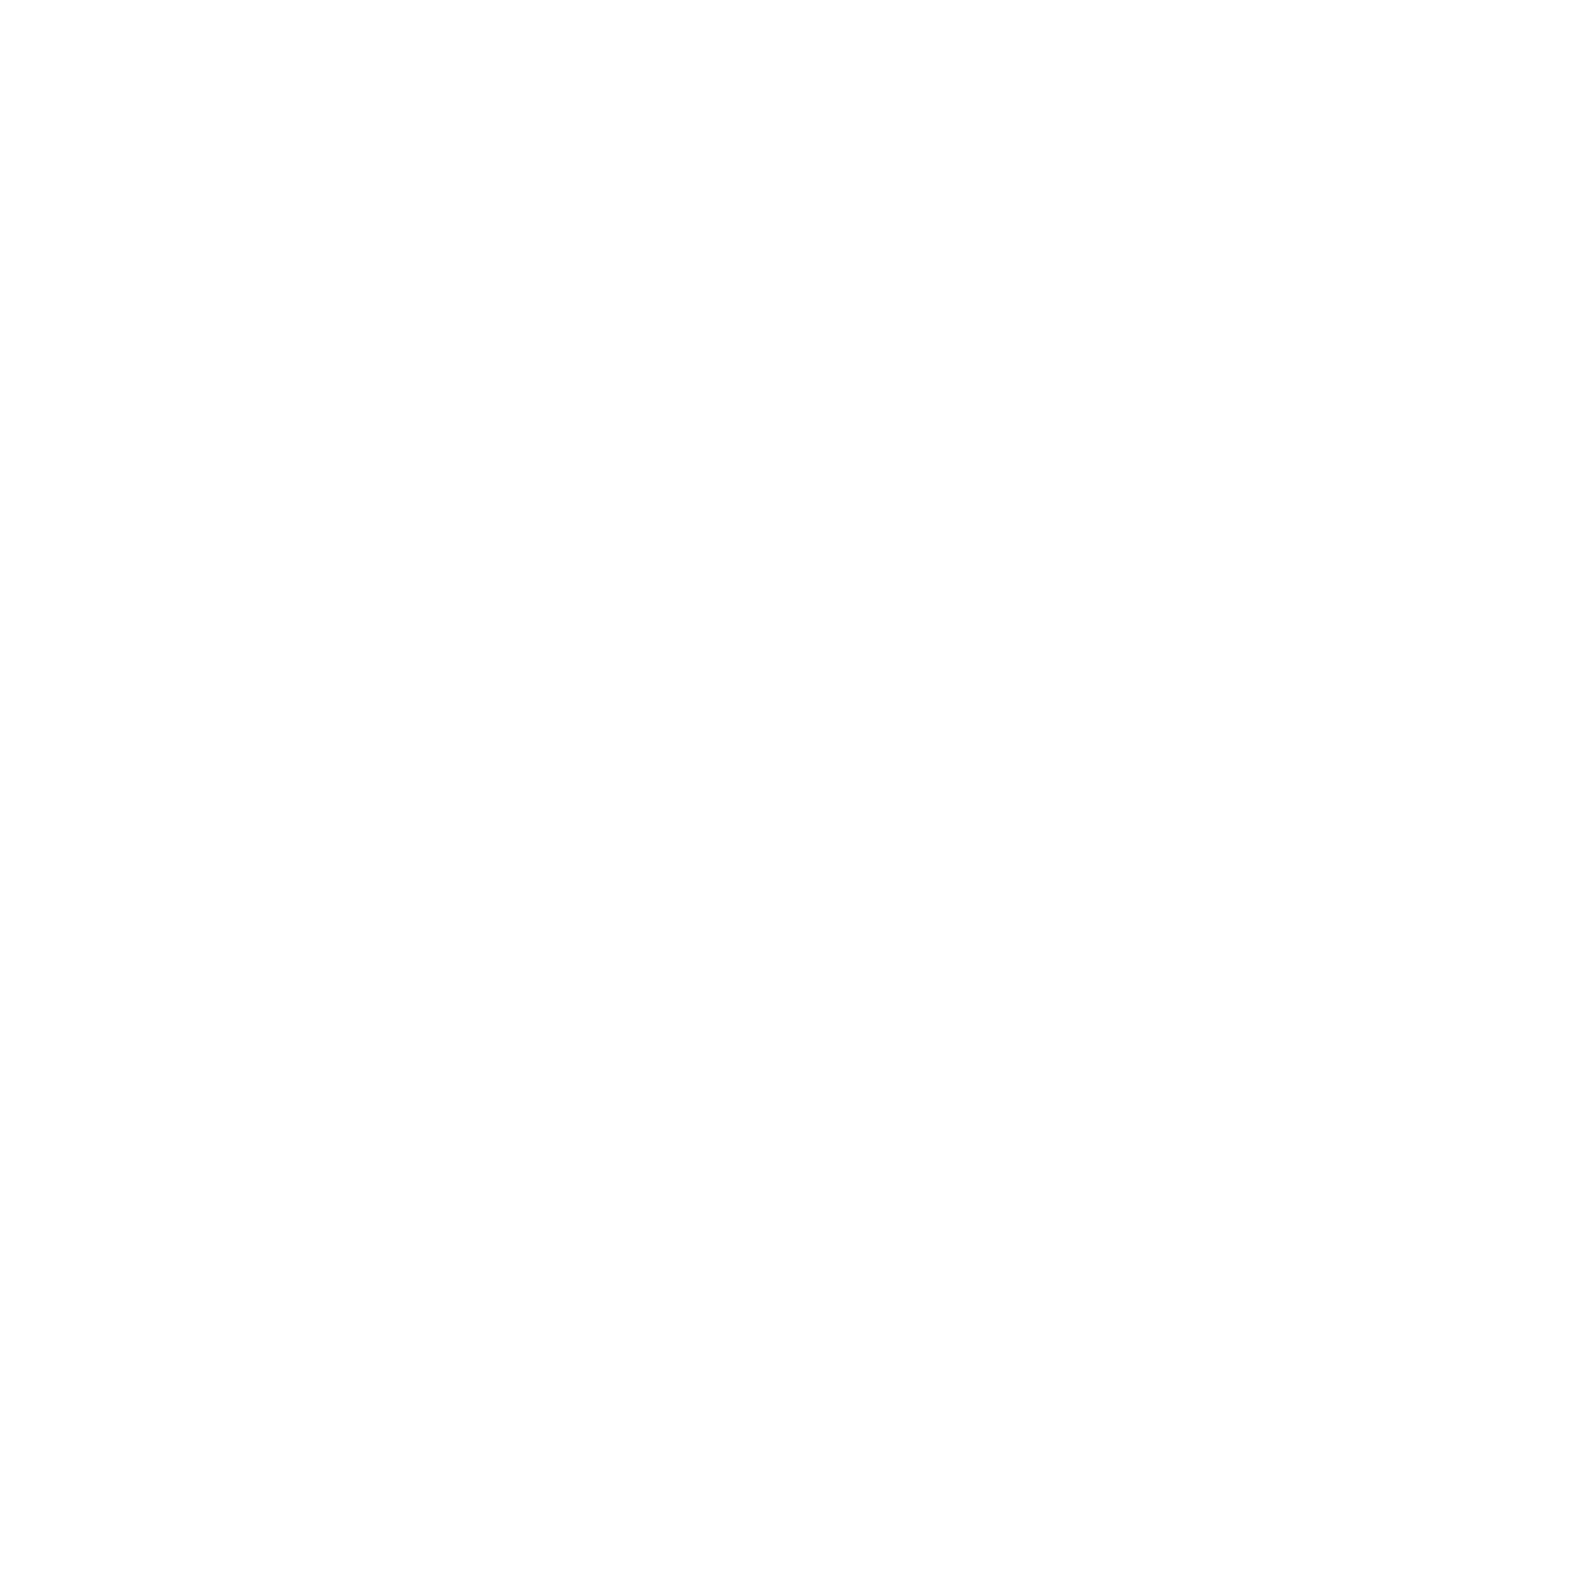

[Epoch 0/9] [Batch 1/9] [D loss: 1.536277, acc:   0%] [G loss: 6.352916] time: 0:00:13.980168
[Epoch 0/9] [Batch 2/9] [D loss: 0.572266, acc:   0%] [G loss: 6.129527] time: 0:00:15.246181
[Epoch 0/9] [Batch 3/9] [D loss: 0.446234, acc:   0%] [G loss: 6.099432] time: 0:00:16.552114
[Epoch 0/9] [Batch 4/9] [D loss: 0.423511, acc:   0%] [G loss: 5.958802] time: 0:00:17.842979
[Epoch 0/9] [Batch 5/9] [D loss: 0.408845, acc:   0%] [G loss: 5.922914] time: 0:00:19.159842
[Epoch 0/9] [Batch 6/9] [D loss: 0.403718, acc:   0%] [G loss: 5.816363] time: 0:00:20.209529
[Epoch 0/9] [Batch 7/9] [D loss: 0.396818, acc:   0%] [G loss: 6.096081] time: 0:00:21.526436
[Epoch 0/9] [Batch 8/9] [D loss: 0.389574, acc:   0%] [G loss: 5.846245] time: 0:00:22.777323
[Epoch 1/9] [Batch 0/9] [D loss: 0.388163, acc:   0%] [G loss: 6.228006] time: 0:00:23.935083


<IPython.core.display.Javascript object>


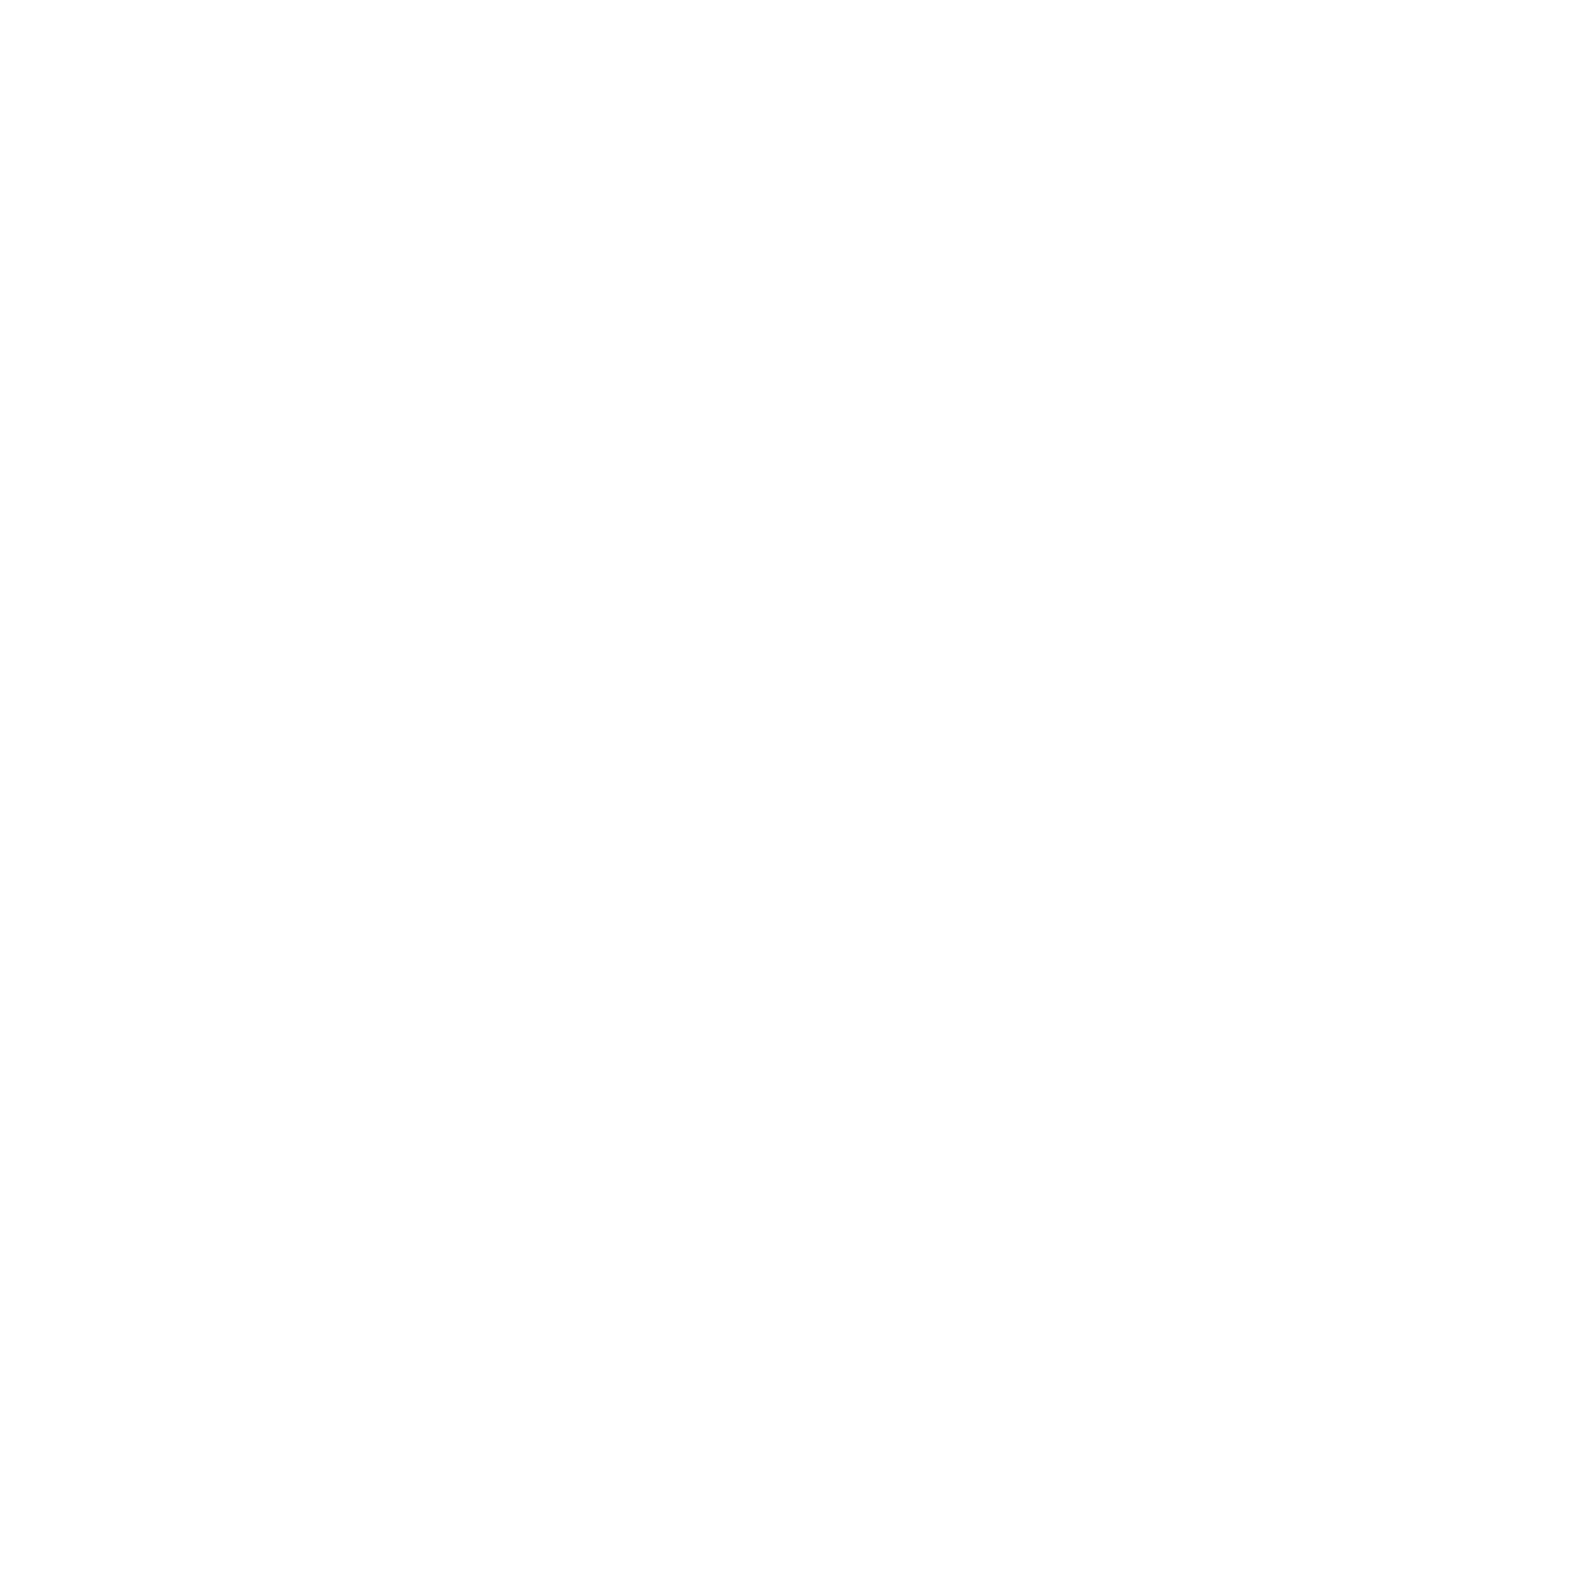

[Epoch 1/9] [Batch 1/9] [D loss: 0.380134, acc:   0%] [G loss: 5.693919] time: 0:00:26.143542
[Epoch 1/9] [Batch 2/9] [D loss: 0.376663, acc:   0%] [G loss: 5.985410] time: 0:00:27.192740
[Epoch 1/9] [Batch 3/9] [D loss: 0.367694, acc:   0%] [G loss: 6.000373] time: 0:00:28.244430
[Epoch 1/9] [Batch 4/9] [D loss: 0.362446, acc:   0%] [G loss: 5.870596] time: 0:00:29.310128
[Epoch 1/9] [Batch 5/9] [D loss: 0.356233, acc:   0%] [G loss: 5.837841] time: 0:00:30.379830
[Epoch 1/9] [Batch 6/9] [D loss: 0.359430, acc:   0%] [G loss: 5.747494] time: 0:00:31.521577
[Epoch 1/9] [Batch 7/9] [D loss: 0.364268, acc:   0%] [G loss: 6.030369] time: 0:00:32.587275
[Epoch 1/9] [Batch 8/9] [D loss: 0.350896, acc:   0%] [G loss: 5.762614] time: 0:00:33.650468
[Epoch 2/9] [Batch 0/9] [D loss: 0.364396, acc:   0%] [G loss: 6.288249] time: 0:00:34.695159


<IPython.core.display.Javascript object>


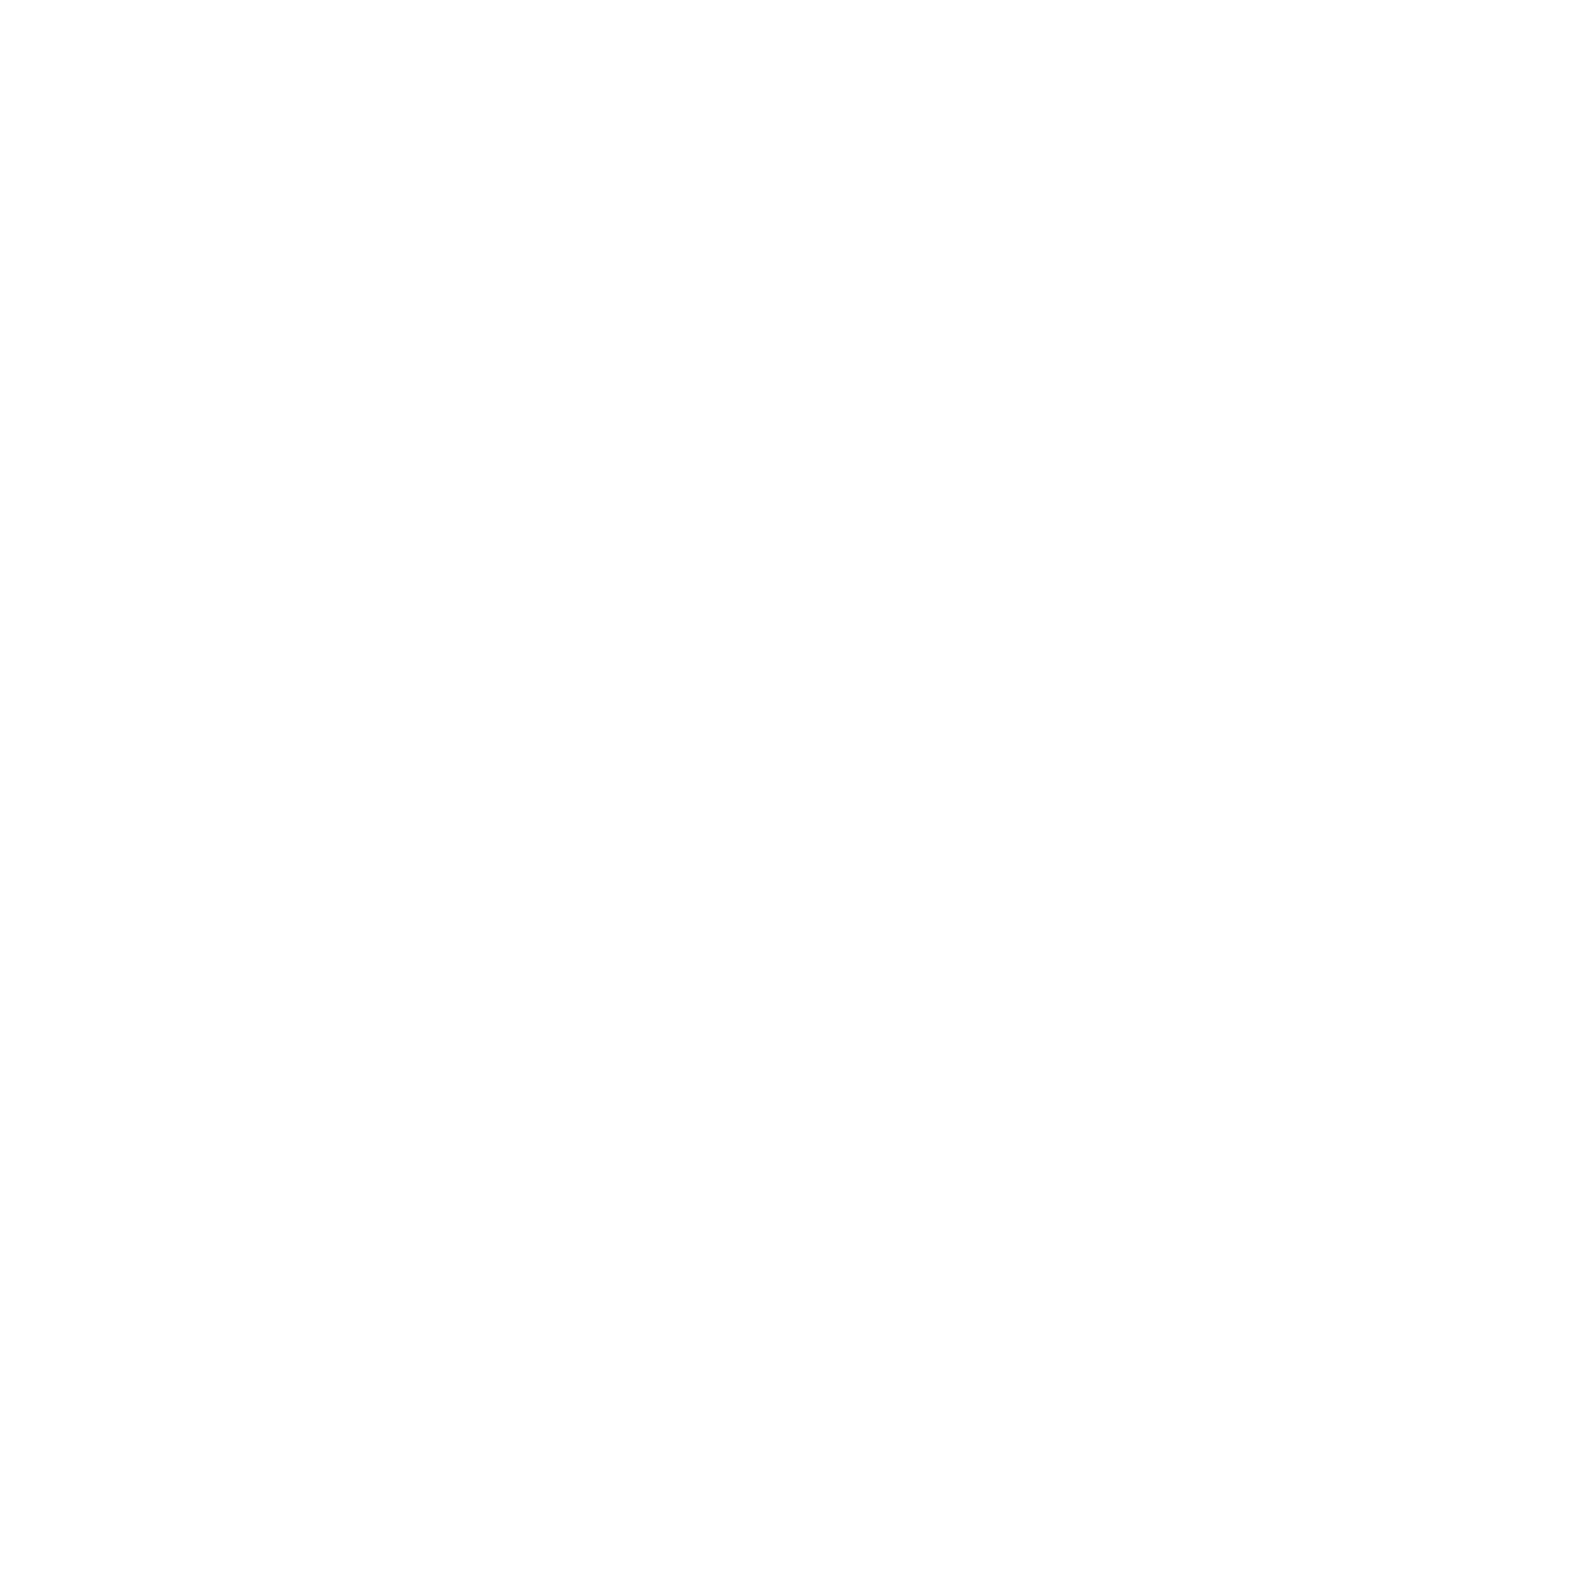

[Epoch 2/9] [Batch 1/9] [D loss: 0.437916, acc:   0%] [G loss: 5.634226] time: 0:00:36.752033
[Epoch 2/9] [Batch 2/9] [D loss: 0.344463, acc:   0%] [G loss: 5.906556] time: 0:00:37.811727
[Epoch 2/9] [Batch 3/9] [D loss: 0.325737, acc:   0%] [G loss: 5.915648] time: 0:00:38.866452
[Epoch 2/9] [Batch 4/9] [D loss: 0.314889, acc:   0%] [G loss: 5.784068] time: 0:00:39.937814
[Epoch 2/9] [Batch 5/9] [D loss: 0.312461, acc:   0%] [G loss: 5.770766] time: 0:00:40.985947
[Epoch 2/9] [Batch 6/9] [D loss: 0.317735, acc:   0%] [G loss: 5.652418] time: 0:00:42.039669
[Epoch 2/9] [Batch 7/9] [D loss: 0.303499, acc:   0%] [G loss: 5.929633] time: 0:00:43.113489
[Epoch 2/9] [Batch 8/9] [D loss: 0.309778, acc:   0%] [G loss: 5.791350] time: 0:00:44.180214
[Epoch 3/9] [Batch 0/9] [D loss: 0.444310, acc:   0%] [G loss: 6.299534] time: 0:00:45.229910


<IPython.core.display.Javascript object>


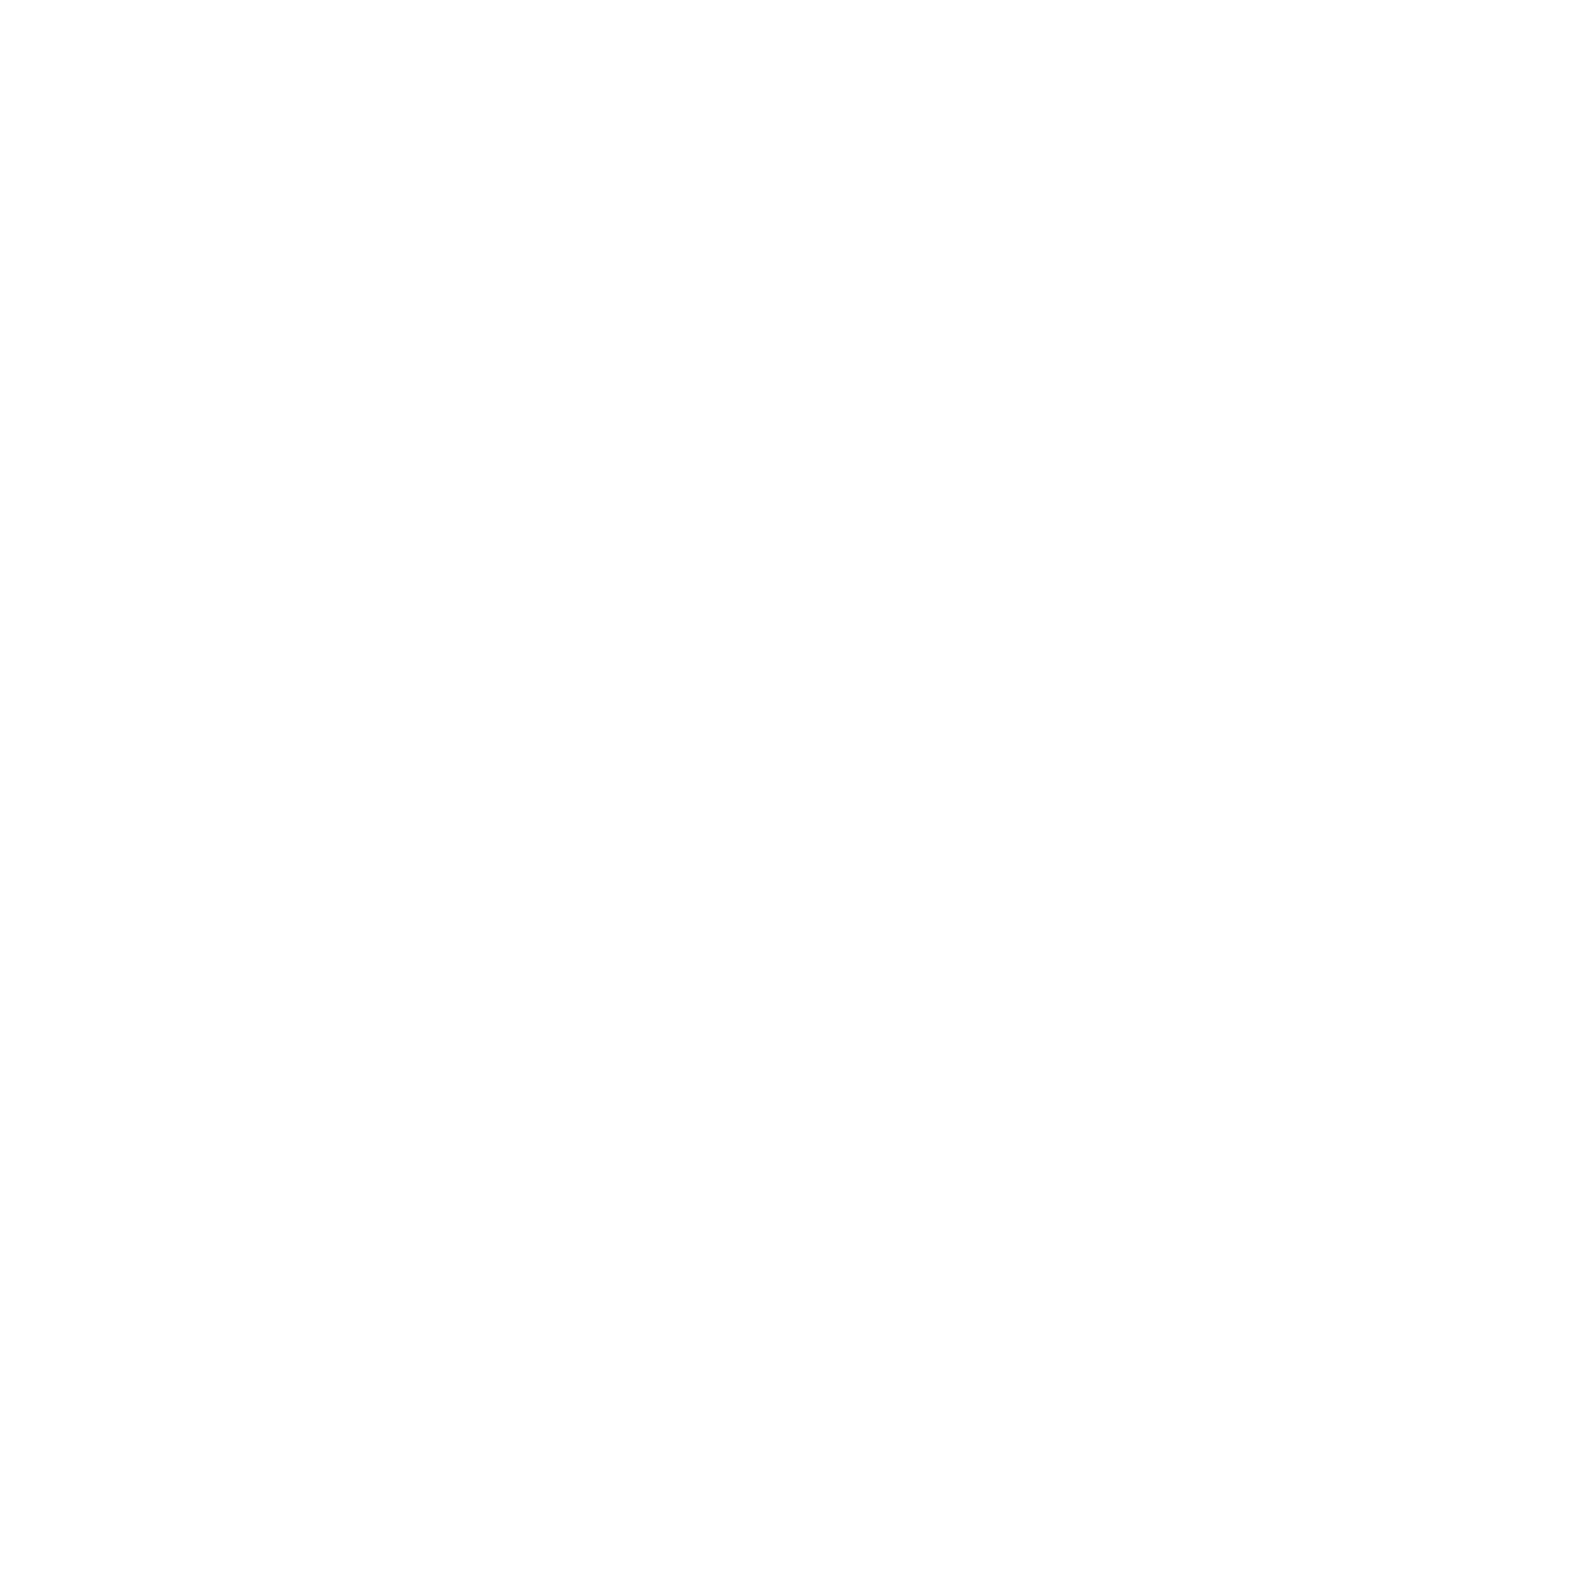

[Epoch 3/9] [Batch 1/9] [D loss: 0.409483, acc:   0%] [G loss: 5.566604] time: 0:00:47.305270
[Epoch 3/9] [Batch 2/9] [D loss: 0.315028, acc:   0%] [G loss: 5.847806] time: 0:00:48.374972
[Epoch 3/9] [Batch 3/9] [D loss: 0.289095, acc:   0%] [G loss: 5.853969] time: 0:00:49.456180
[Epoch 3/9] [Batch 4/9] [D loss: 0.280828, acc:   0%] [G loss: 5.723350] time: 0:00:50.510439
[Epoch 3/9] [Batch 5/9] [D loss: 0.276275, acc:   0%] [G loss: 5.688987] time: 0:00:51.575137
[Epoch 3/9] [Batch 6/9] [D loss: 0.275117, acc:   0%] [G loss: 5.587416] time: 0:00:52.652342
[Epoch 3/9] [Batch 7/9] [D loss: 0.269790, acc:   0%] [G loss: 5.870560] time: 0:00:53.697564
[Epoch 3/9] [Batch 8/9] [D loss: 0.267159, acc:   0%] [G loss: 5.615215] time: 0:00:54.743249
[Epoch 4/9] [Batch 0/9] [D loss: 0.263663, acc:   0%] [G loss: 6.013655] time: 0:00:55.790650


<IPython.core.display.Javascript object>


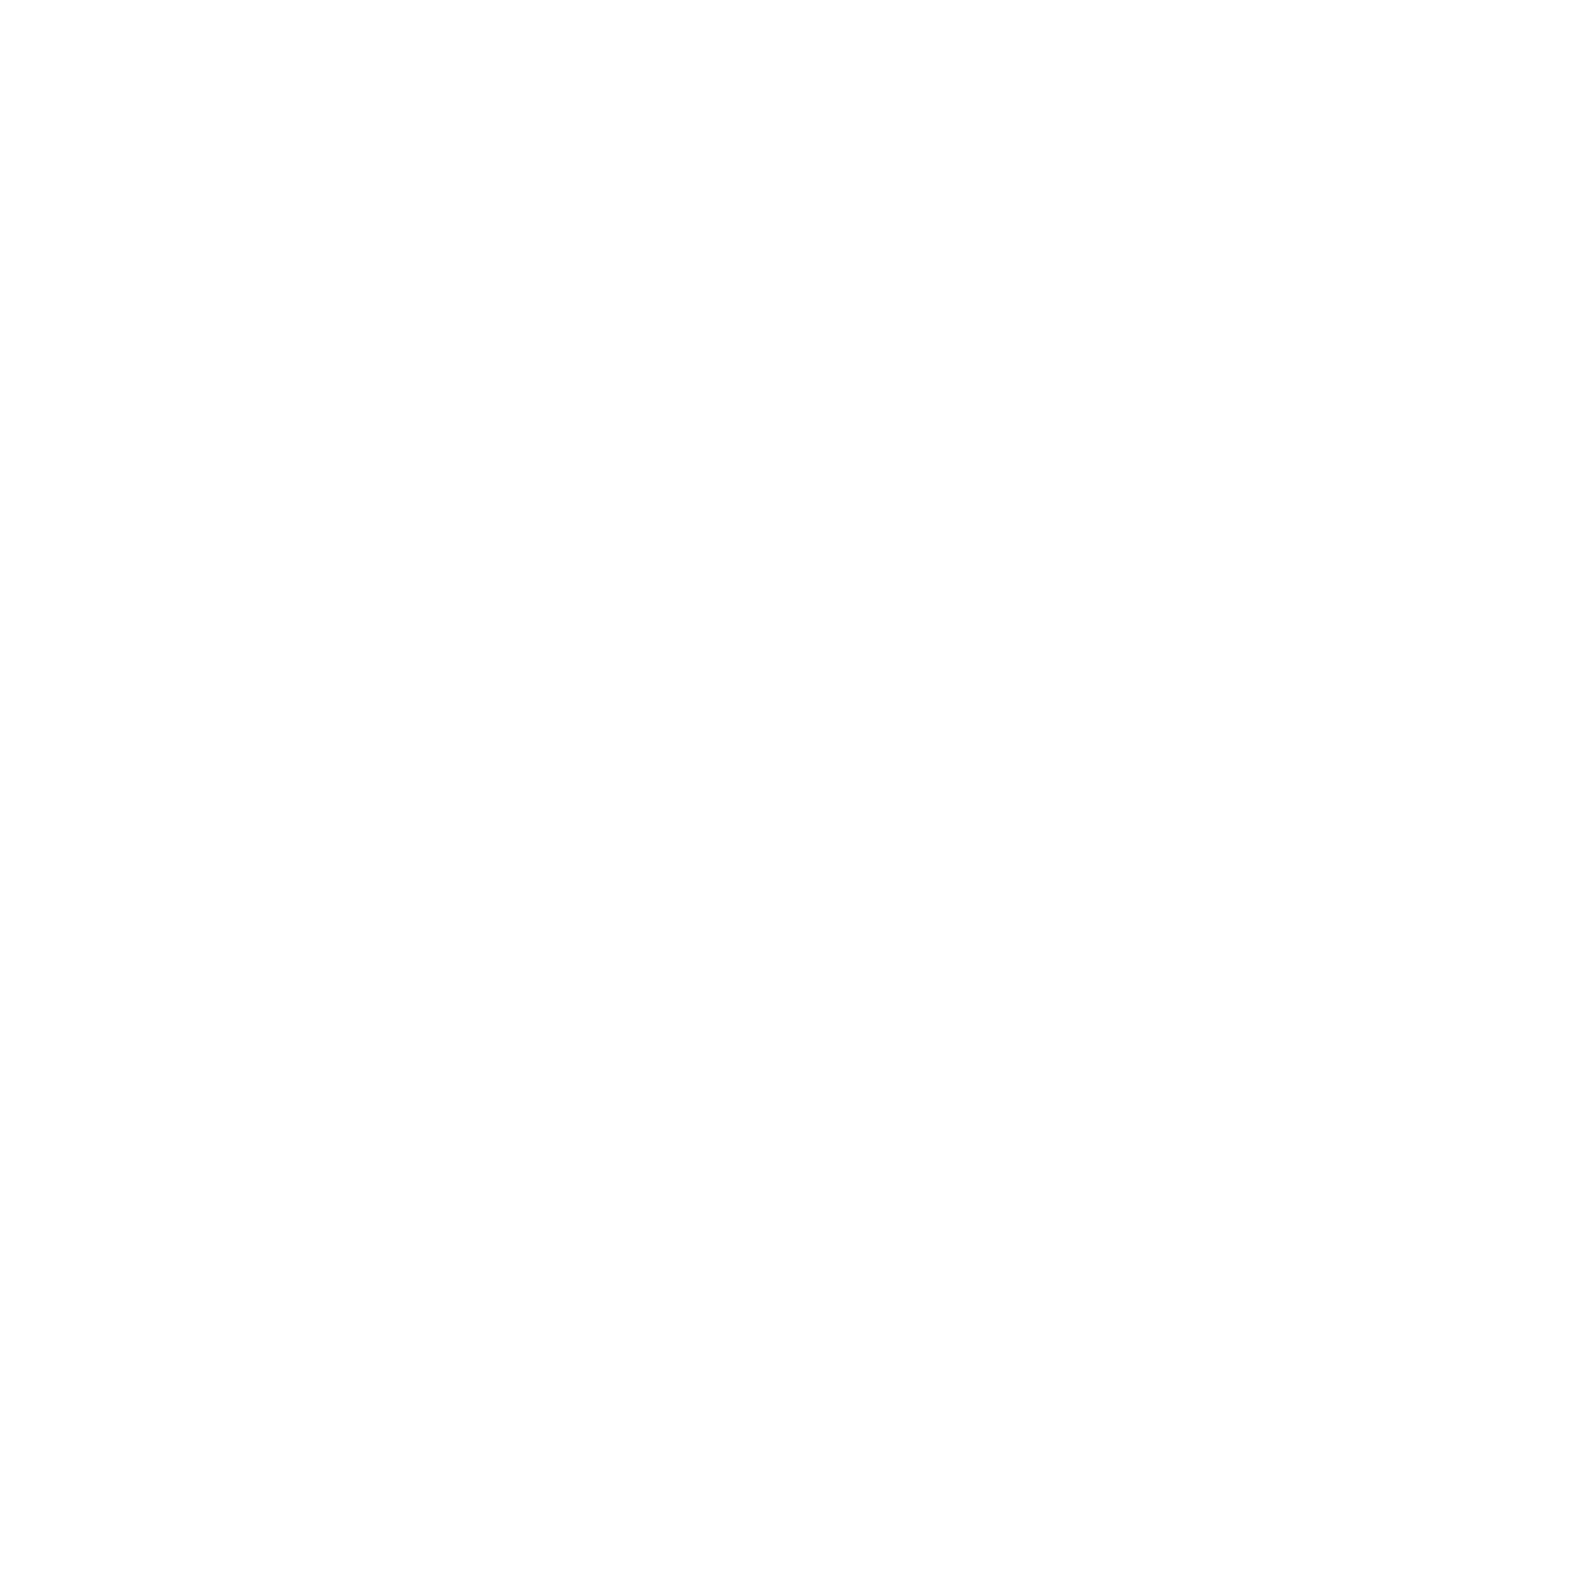

[Epoch 4/9] [Batch 1/9] [D loss: 0.294979, acc:   0%] [G loss: 5.568679] time: 0:00:57.903609
[Epoch 4/9] [Batch 2/9] [D loss: 0.345158, acc:   0%] [G loss: 5.869823] time: 0:00:58.963407
[Epoch 4/9] [Batch 3/9] [D loss: 0.319368, acc:   0%] [G loss: 5.797400] time: 0:01:00.025189
[Epoch 4/9] [Batch 4/9] [D loss: 0.257705, acc:   0%] [G loss: 5.652409] time: 0:01:01.089655
[Epoch 4/9] [Batch 5/9] [D loss: 0.241770, acc:   0%] [G loss: 5.618675] time: 0:01:02.166877
[Epoch 4/9] [Batch 6/9] [D loss: 0.241993, acc:   0%] [G loss: 5.528980] time: 0:01:03.213315
[Epoch 4/9] [Batch 7/9] [D loss: 0.251725, acc:   0%] [G loss: 5.818504] time: 0:01:04.271803
[Epoch 4/9] [Batch 8/9] [D loss: 0.247992, acc:   0%] [G loss: 5.549967] time: 0:01:05.342209
[Epoch 5/9] [Batch 0/9] [D loss: 0.235762, acc:   0%] [G loss: 5.949584] time: 0:01:06.417798


<IPython.core.display.Javascript object>


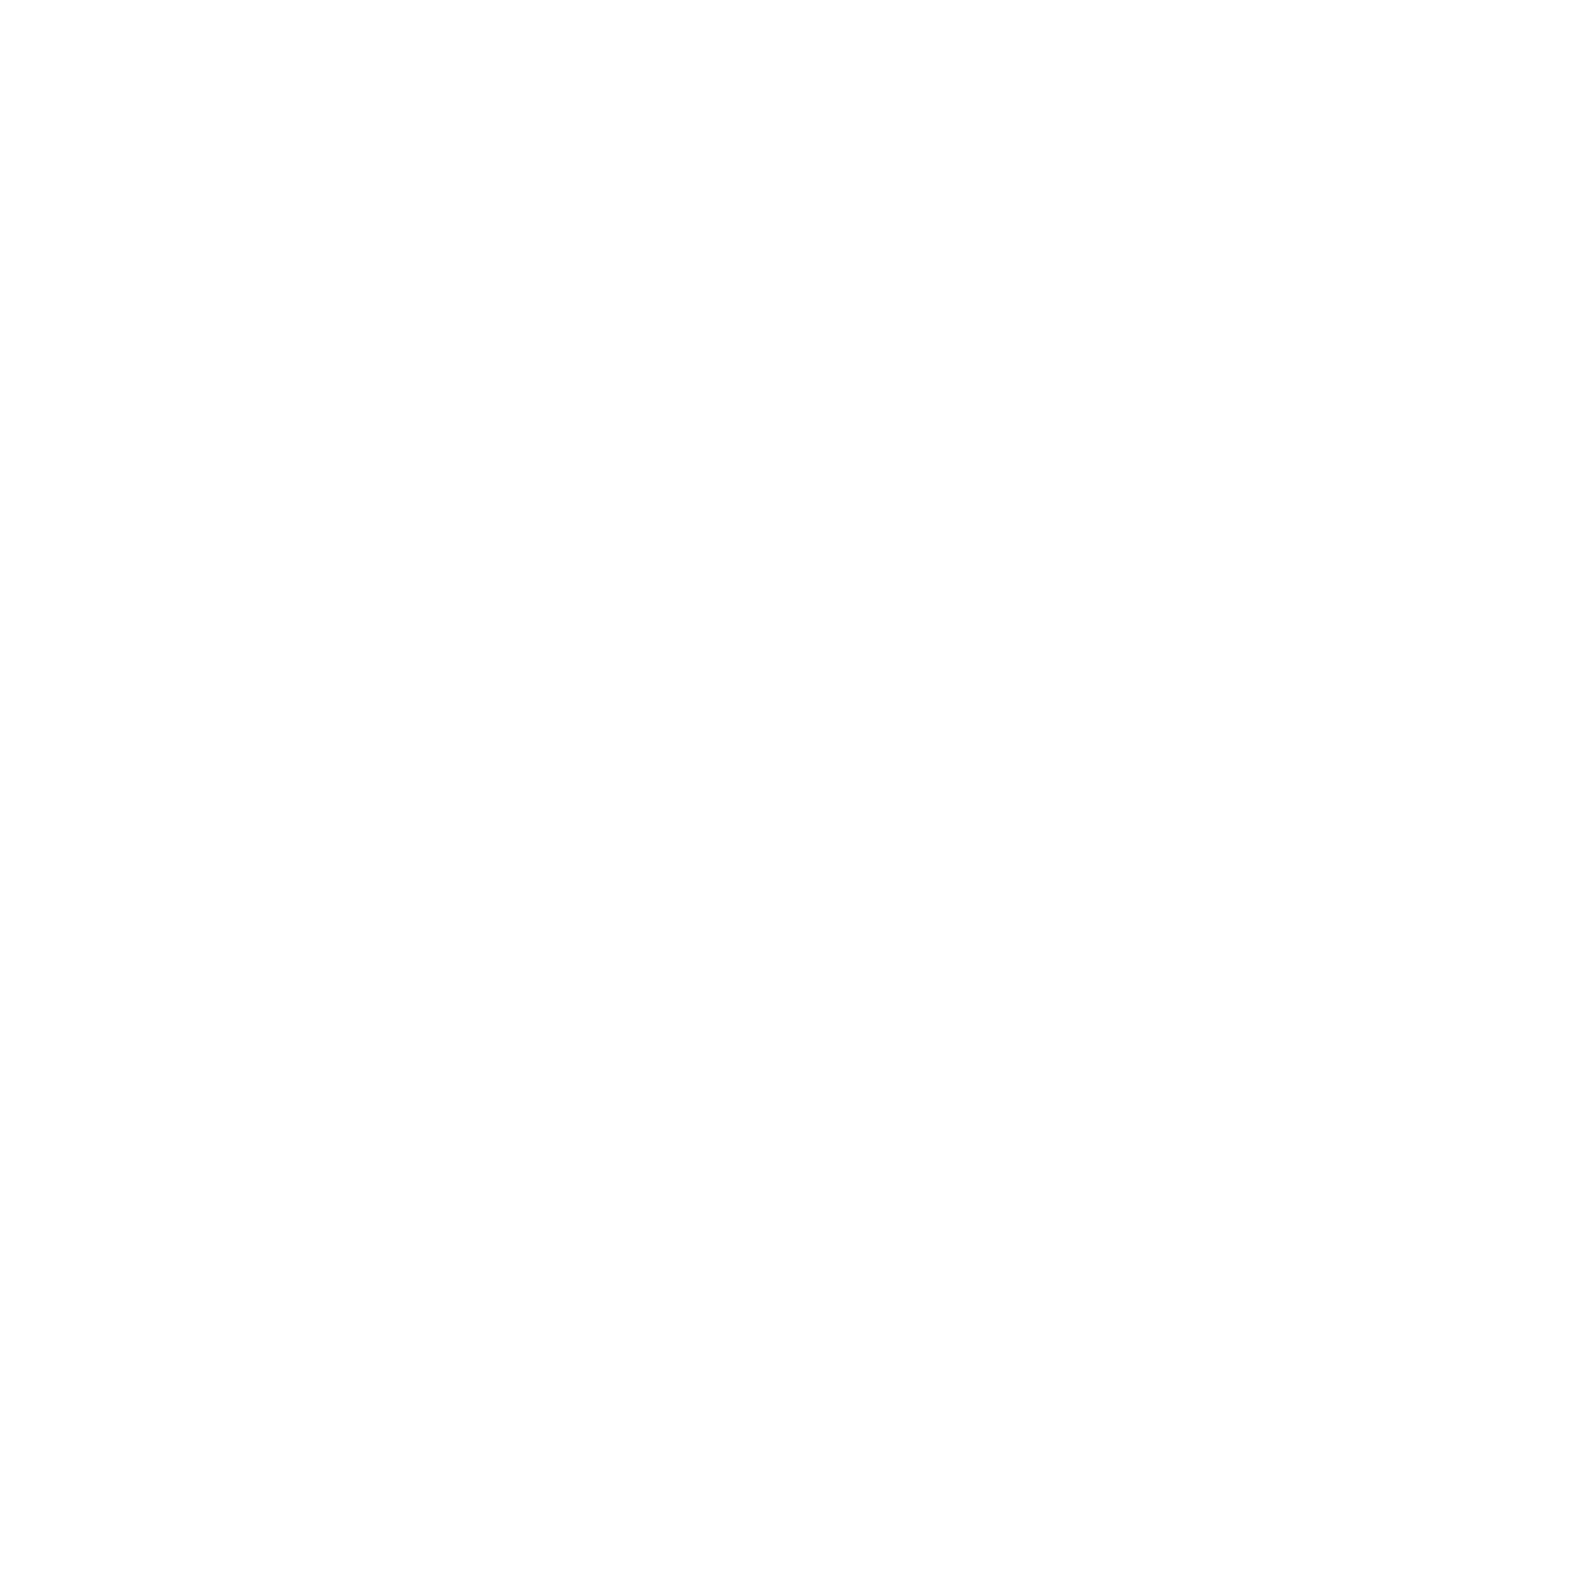

[Epoch 5/9] [Batch 1/9] [D loss: 0.289472, acc:   0%] [G loss: 5.485106] time: 0:01:08.485141
[Epoch 5/9] [Batch 2/9] [D loss: 0.271723, acc:   0%] [G loss: 5.715167] time: 0:01:09.540729
[Epoch 5/9] [Batch 3/9] [D loss: 0.222927, acc:   0%] [G loss: 5.721462] time: 0:01:10.615318
[Epoch 5/9] [Batch 4/9] [D loss: 0.217501, acc:   0%] [G loss: 5.588785] time: 0:01:11.670576
[Epoch 5/9] [Batch 5/9] [D loss: 0.211133, acc:   0%] [G loss: 5.554364] time: 0:01:12.729283
[Epoch 5/9] [Batch 6/9] [D loss: 0.216926, acc:   0%] [G loss: 5.488605] time: 0:01:13.786562
[Epoch 5/9] [Batch 7/9] [D loss: 0.278896, acc:   0%] [G loss: 5.906823] time: 0:01:14.848494
[Epoch 5/9] [Batch 8/9] [D loss: 0.319103, acc:   0%] [G loss: 5.514148] time: 0:01:15.923050
[Epoch 6/9] [Batch 0/9] [D loss: 0.219413, acc:   0%] [G loss: 5.890239] time: 0:01:16.996439


<IPython.core.display.Javascript object>


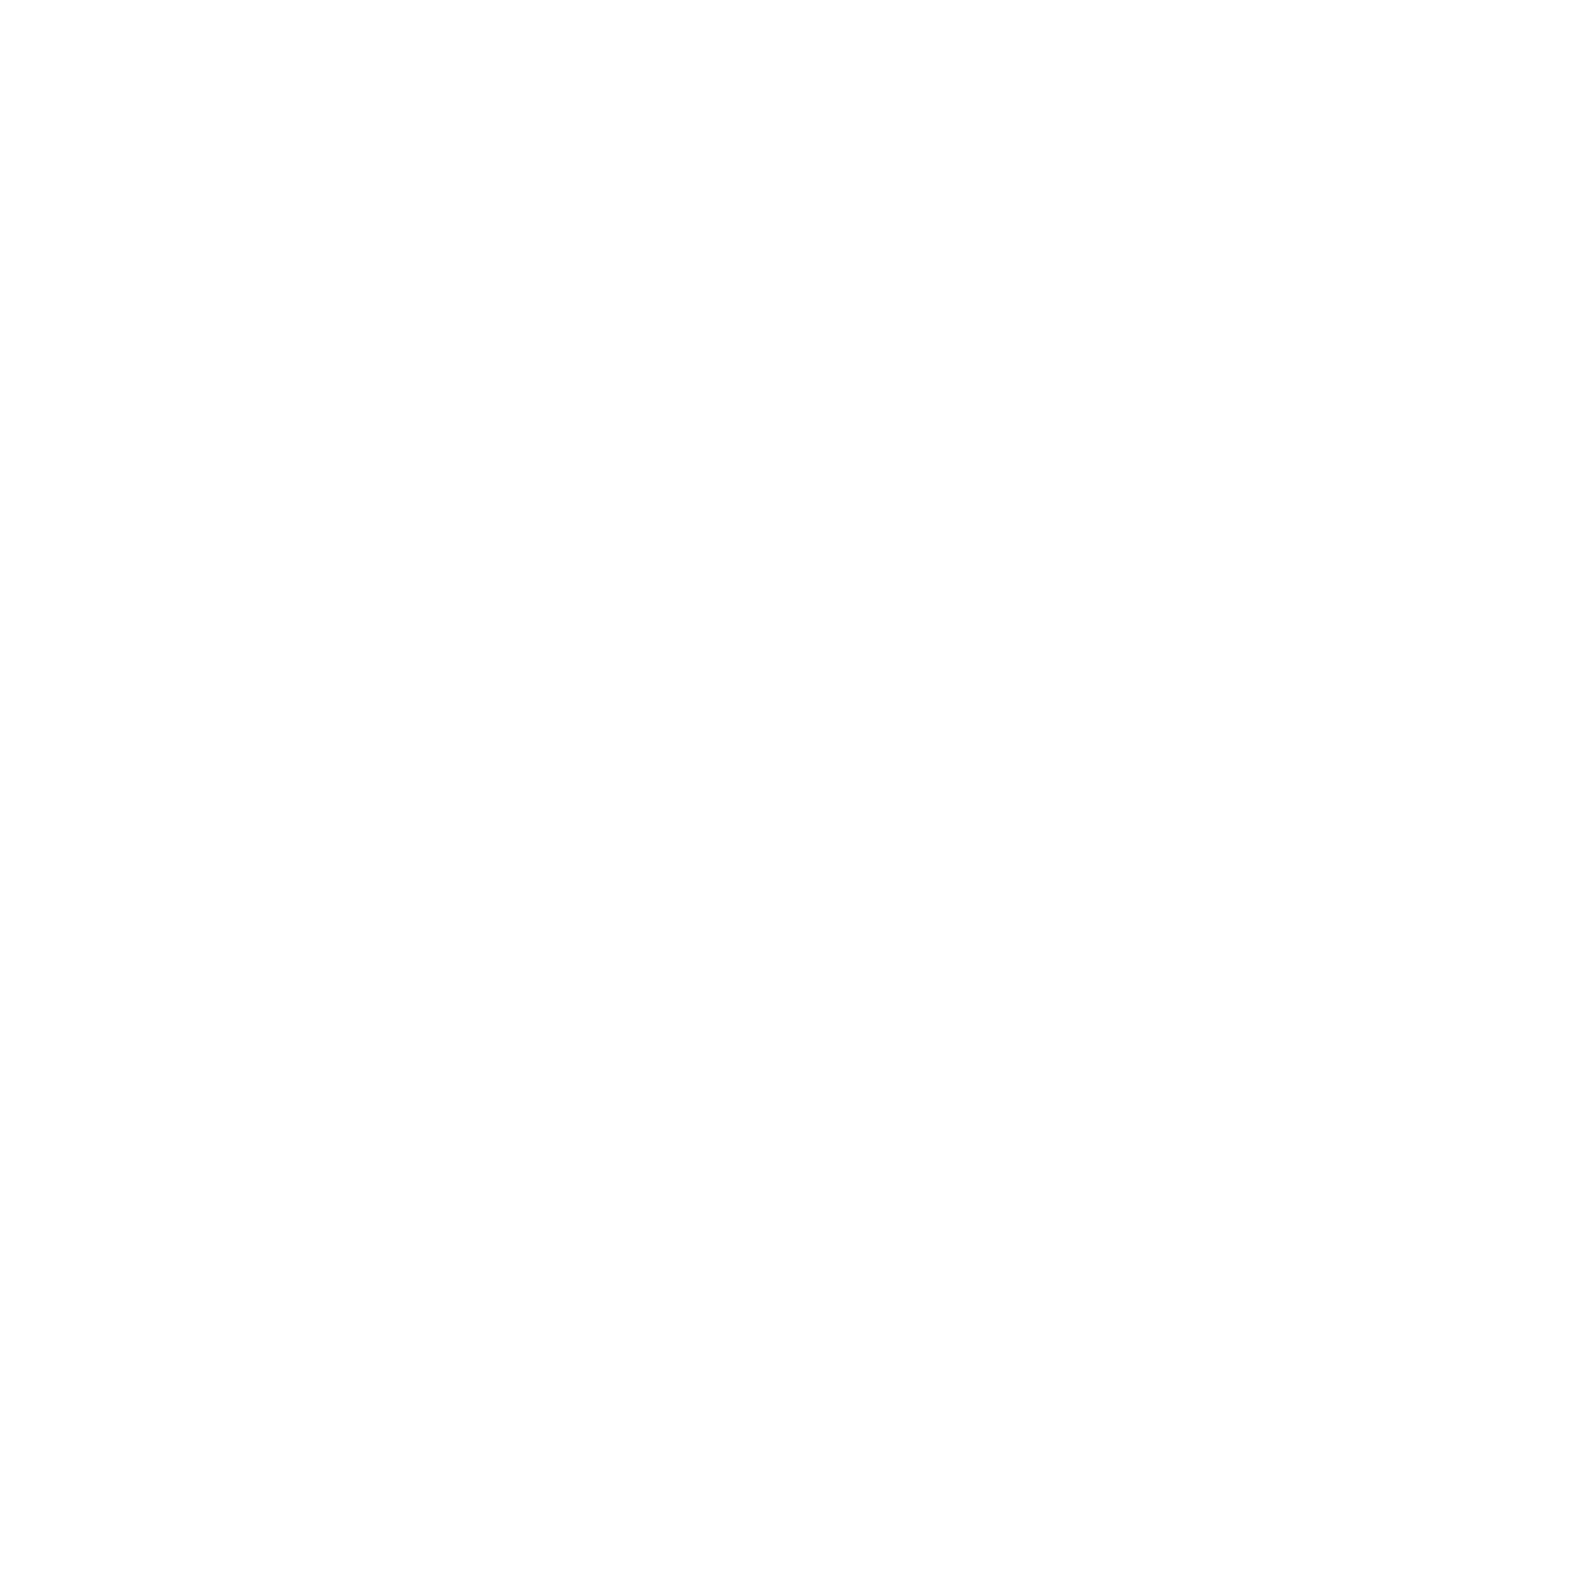

[Epoch 6/9] [Batch 1/9] [D loss: 0.209214, acc:   0%] [G loss: 5.345674] time: 0:01:19.320105
[Epoch 6/9] [Batch 2/9] [D loss: 0.200013, acc:   0%] [G loss: 5.636796] time: 0:01:20.376733
[Epoch 6/9] [Batch 3/9] [D loss: 0.193539, acc:   0%] [G loss: 5.649736] time: 0:01:21.448699
[Epoch 6/9] [Batch 4/9] [D loss: 0.187175, acc:   0%] [G loss: 5.518151] time: 0:01:22.501598
[Epoch 6/9] [Batch 5/9] [D loss: 0.181598, acc:   0%] [G loss: 5.483822] time: 0:01:23.558300
[Epoch 6/9] [Batch 6/9] [D loss: 0.188548, acc:   0%] [G loss: 5.423004] time: 0:01:24.804587
[Epoch 6/9] [Batch 7/9] [D loss: 0.258789, acc:   0%] [G loss: 5.955583] time: 0:01:25.873490
[Epoch 6/9] [Batch 8/9] [D loss: 0.420466, acc:   0%] [G loss: 5.583088] time: 0:01:26.945719
[Epoch 7/9] [Batch 0/9] [D loss: 0.283466, acc:   0%] [G loss: 5.850259] time: 0:01:27.999575


<IPython.core.display.Javascript object>


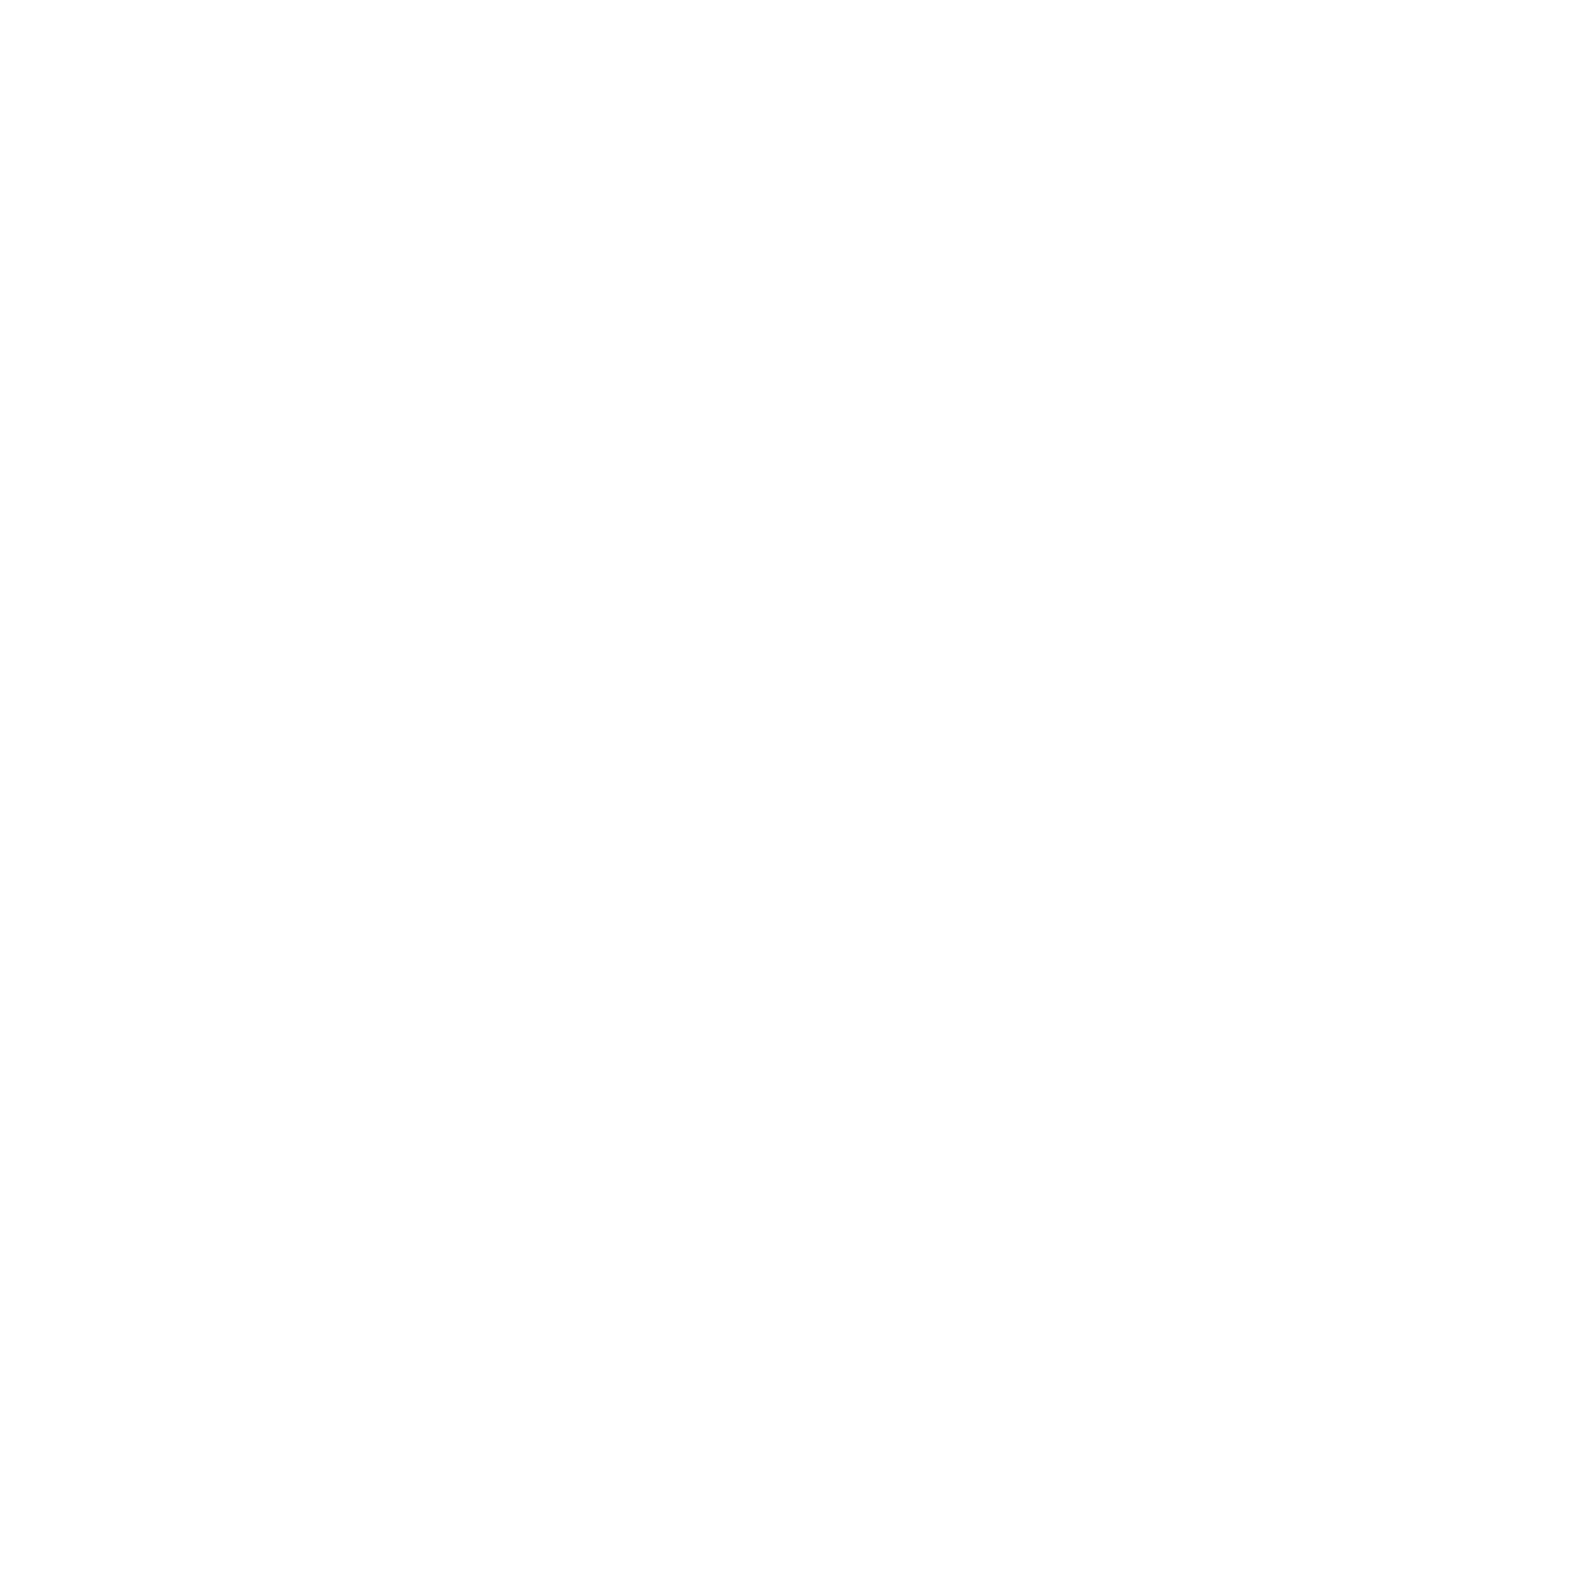

[Epoch 7/9] [Batch 1/9] [D loss: 0.190059, acc:   0%] [G loss: 5.305298] time: 0:01:30.208091
[Epoch 7/9] [Batch 2/9] [D loss: 0.185839, acc:   0%] [G loss: 5.597630] time: 0:01:31.259173
[Epoch 7/9] [Batch 3/9] [D loss: 0.173783, acc:   0%] [G loss: 5.611952] time: 0:01:32.314432
[Epoch 7/9] [Batch 4/9] [D loss: 0.173422, acc:   0%] [G loss: 5.487316] time: 0:01:33.390517
[Epoch 7/9] [Batch 5/9] [D loss: 0.174782, acc:   0%] [G loss: 5.462237] time: 0:01:34.473269
[Epoch 7/9] [Batch 6/9] [D loss: 0.177481, acc:   0%] [G loss: 5.356985] time: 0:01:35.529350
[Epoch 7/9] [Batch 7/9] [D loss: 0.175629, acc:   0%] [G loss: 5.660205] time: 0:01:36.582087
[Epoch 7/9] [Batch 8/9] [D loss: 0.171861, acc:   0%] [G loss: 5.391126] time: 0:01:37.657415
[Epoch 8/9] [Batch 0/9] [D loss: 0.163827, acc:   0%] [G loss: 5.773532] time: 0:01:38.728789


<IPython.core.display.Javascript object>


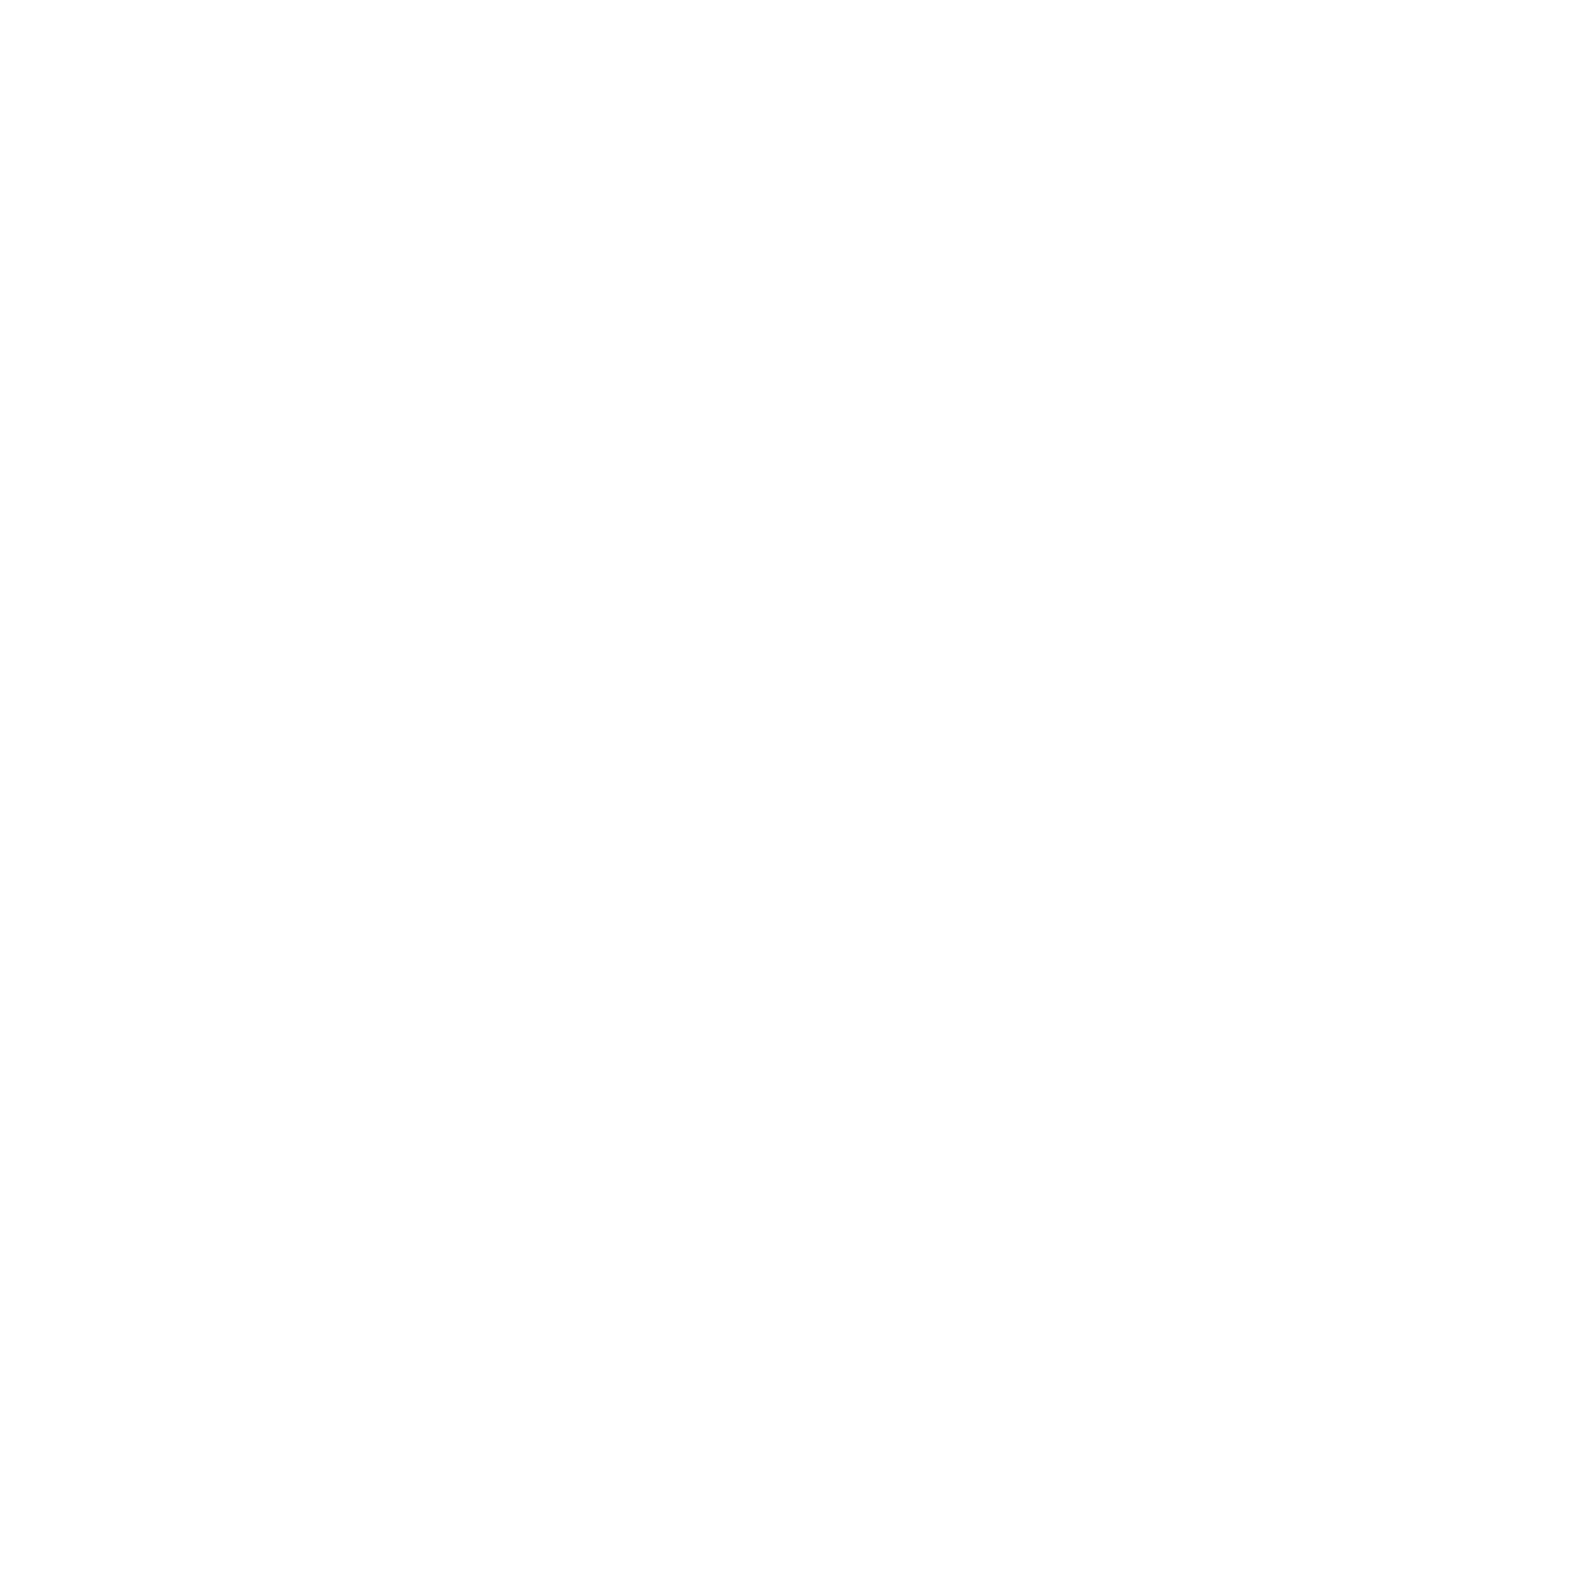

[Epoch 8/9] [Batch 1/9] [D loss: 0.164410, acc:   0%] [G loss: 5.249487] time: 0:01:40.815706
[Epoch 8/9] [Batch 2/9] [D loss: 0.159255, acc:   0%] [G loss: 5.537566] time: 0:01:41.871569
[Epoch 8/9] [Batch 3/9] [D loss: 0.163173, acc:   0%] [G loss: 5.633378] time: 0:01:42.934632
[Epoch 8/9] [Batch 4/9] [D loss: 0.231308, acc:   0%] [G loss: 5.512234] time: 0:01:44.012235
[Epoch 8/9] [Batch 5/9] [D loss: 0.197902, acc:   0%] [G loss: 5.416969] time: 0:01:45.064868
[Epoch 8/9] [Batch 6/9] [D loss: 0.155960, acc:   0%] [G loss: 5.325072] time: 0:01:46.118740
[Epoch 8/9] [Batch 7/9] [D loss: 0.161980, acc:   0%] [G loss: 5.606218] time: 0:01:47.191948
[Epoch 8/9] [Batch 8/9] [D loss: 0.150701, acc:   0%] [G loss: 5.350962] time: 0:01:48.259549
[Epoch 9/9] [Batch 0/9] [D loss: 0.150186, acc:   0%] [G loss: 5.737568] time: 0:01:49.310896


<IPython.core.display.Javascript object>


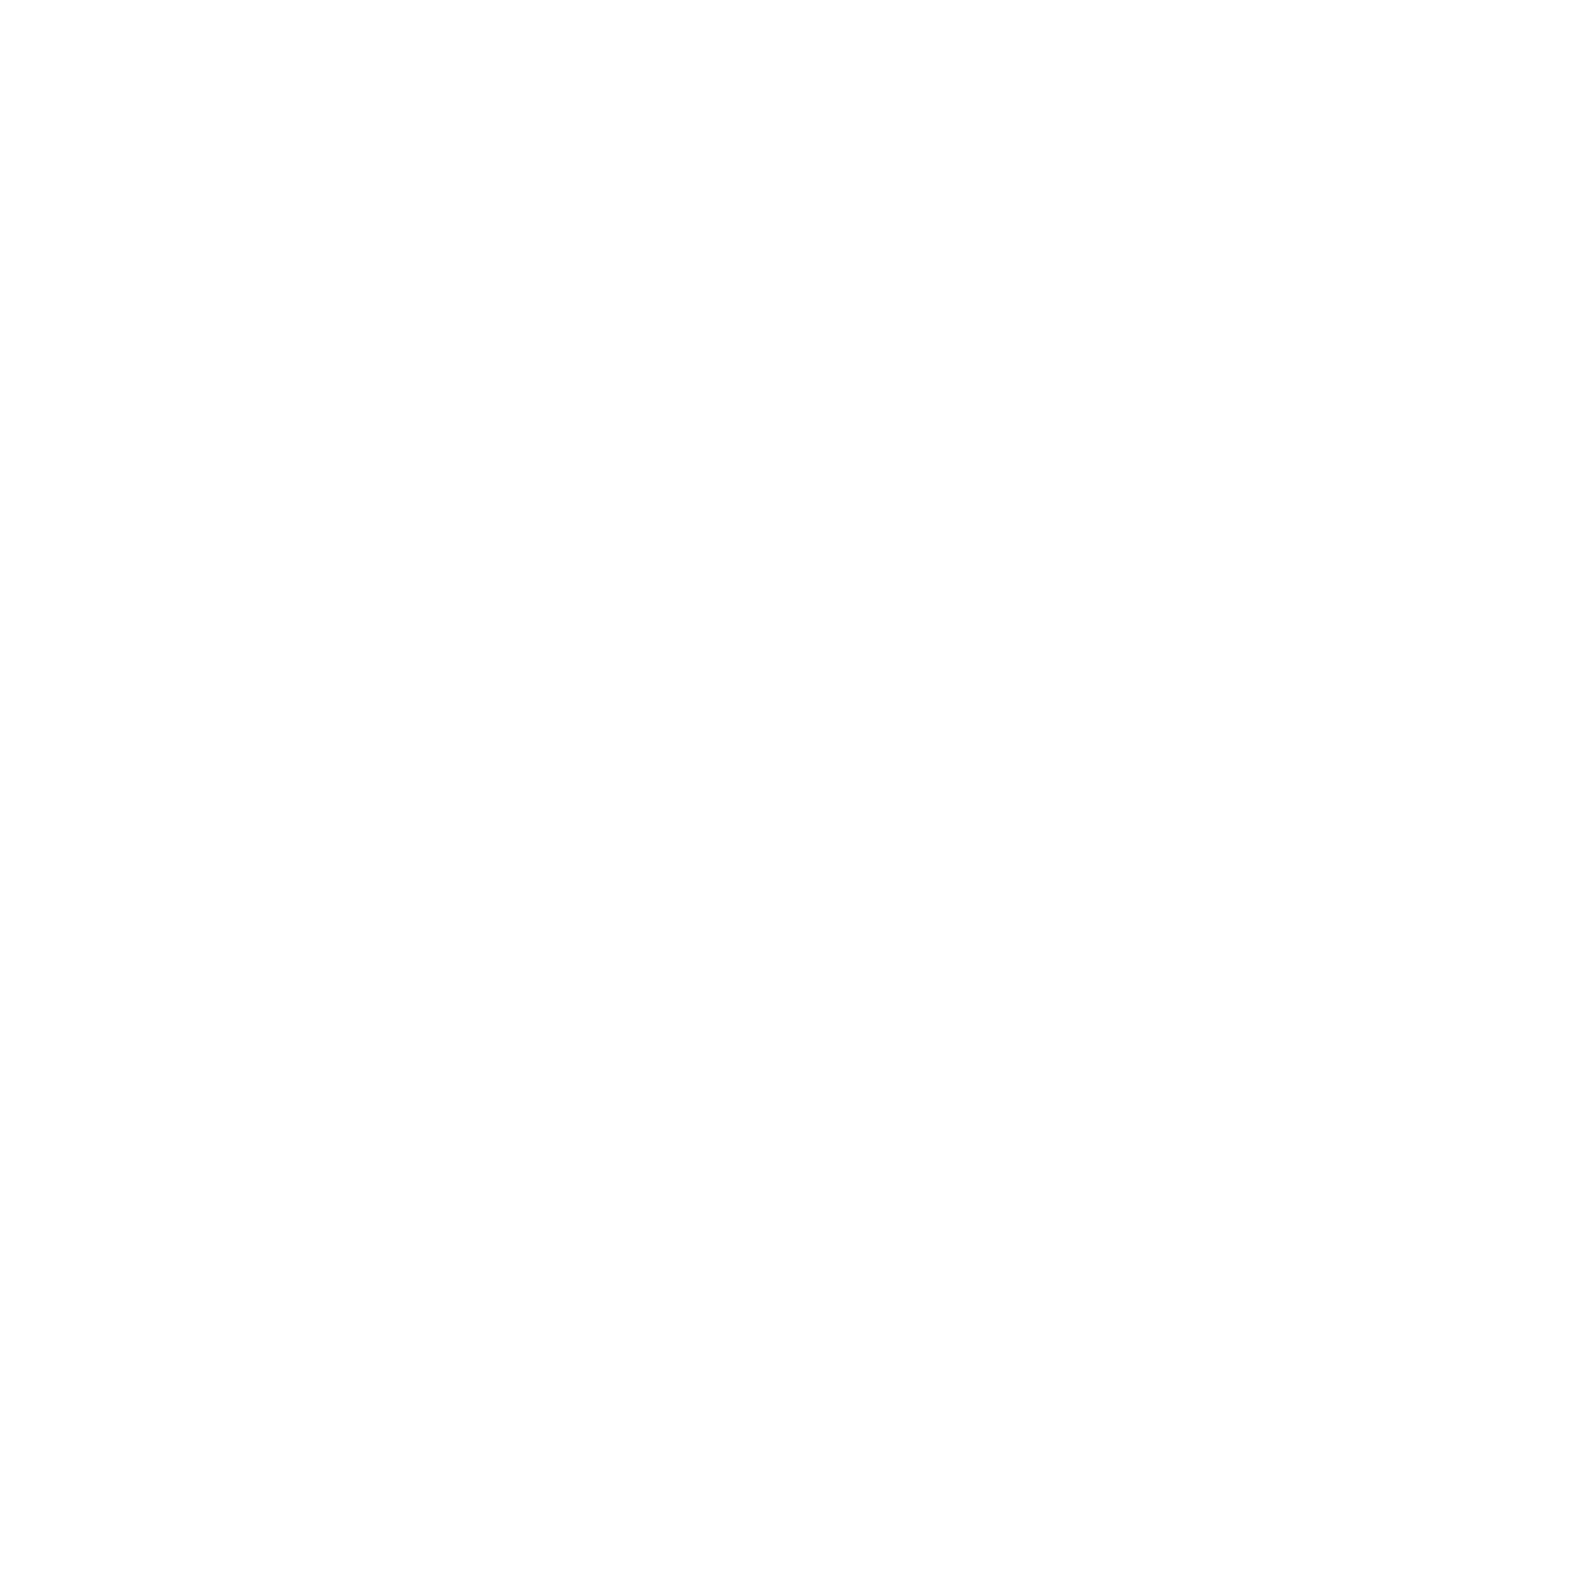

[Epoch 9/9] [Batch 1/9] [D loss: 0.161284, acc:   0%] [G loss: 5.237584] time: 0:01:51.422262
[Epoch 9/9] [Batch 2/9] [D loss: 0.157969, acc:   0%] [G loss: 5.503805] time: 0:01:52.503515
[Epoch 9/9] [Batch 3/9] [D loss: 0.145112, acc:   0%] [G loss: 5.522569] time: 0:01:53.584147
[Epoch 9/9] [Batch 4/9] [D loss: 0.143173, acc:   0%] [G loss: 5.400856] time: 0:01:54.665352
[Epoch 9/9] [Batch 5/9] [D loss: 0.145515, acc:   0%] [G loss: 5.377804] time: 0:01:55.738330
[Epoch 9/9] [Batch 6/9] [D loss: 0.152404, acc:   0%] [G loss: 5.284530] time: 0:01:56.815642
[Epoch 9/9] [Batch 7/9] [D loss: 0.158928, acc:   0%] [G loss: 5.585495] time: 0:01:57.895519
[Epoch 9/9] [Batch 8/9] [D loss: 0.150522, acc:   0%] [G loss: 5.315838] time: 0:01:58.948984

Finish training in (hh:mm:ss.ms) 0:01:58.950985


In [99]:
epochs = 10

gan.train(epochs=epochs, add_noise=False)
# gan.train(epochs=epochs, add_noise=True)

In [58]:
stack_manip = [ dl.MANIPULATION.SPATIAL_DOWN, 
                dl.MANIPULATION.SPATIAL_RESIZE, 
                dl.MANIPULATION.FREQUENCY_DOWN
              ]

### sample images from generator

In [16]:
p = time.strftime("%Y-%m-%d_%H_%M_%S")
gan.sample_images(epoch=0, batch_i=0, p=p)

### release GPU memory

In [53]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

185567

In [54]:
delete_model_memory = False

if delete_model_memory:
    try:
        del gan, discriminator, combined, generator 
    except:
        print('models not available')

### plot random volume with 3 random stacks of GAN

plotted volume: images/NESb\NESb_2018-08-13_13_49_04_FREQUENCY_UP\1_0_FREQUENCY_UP.png


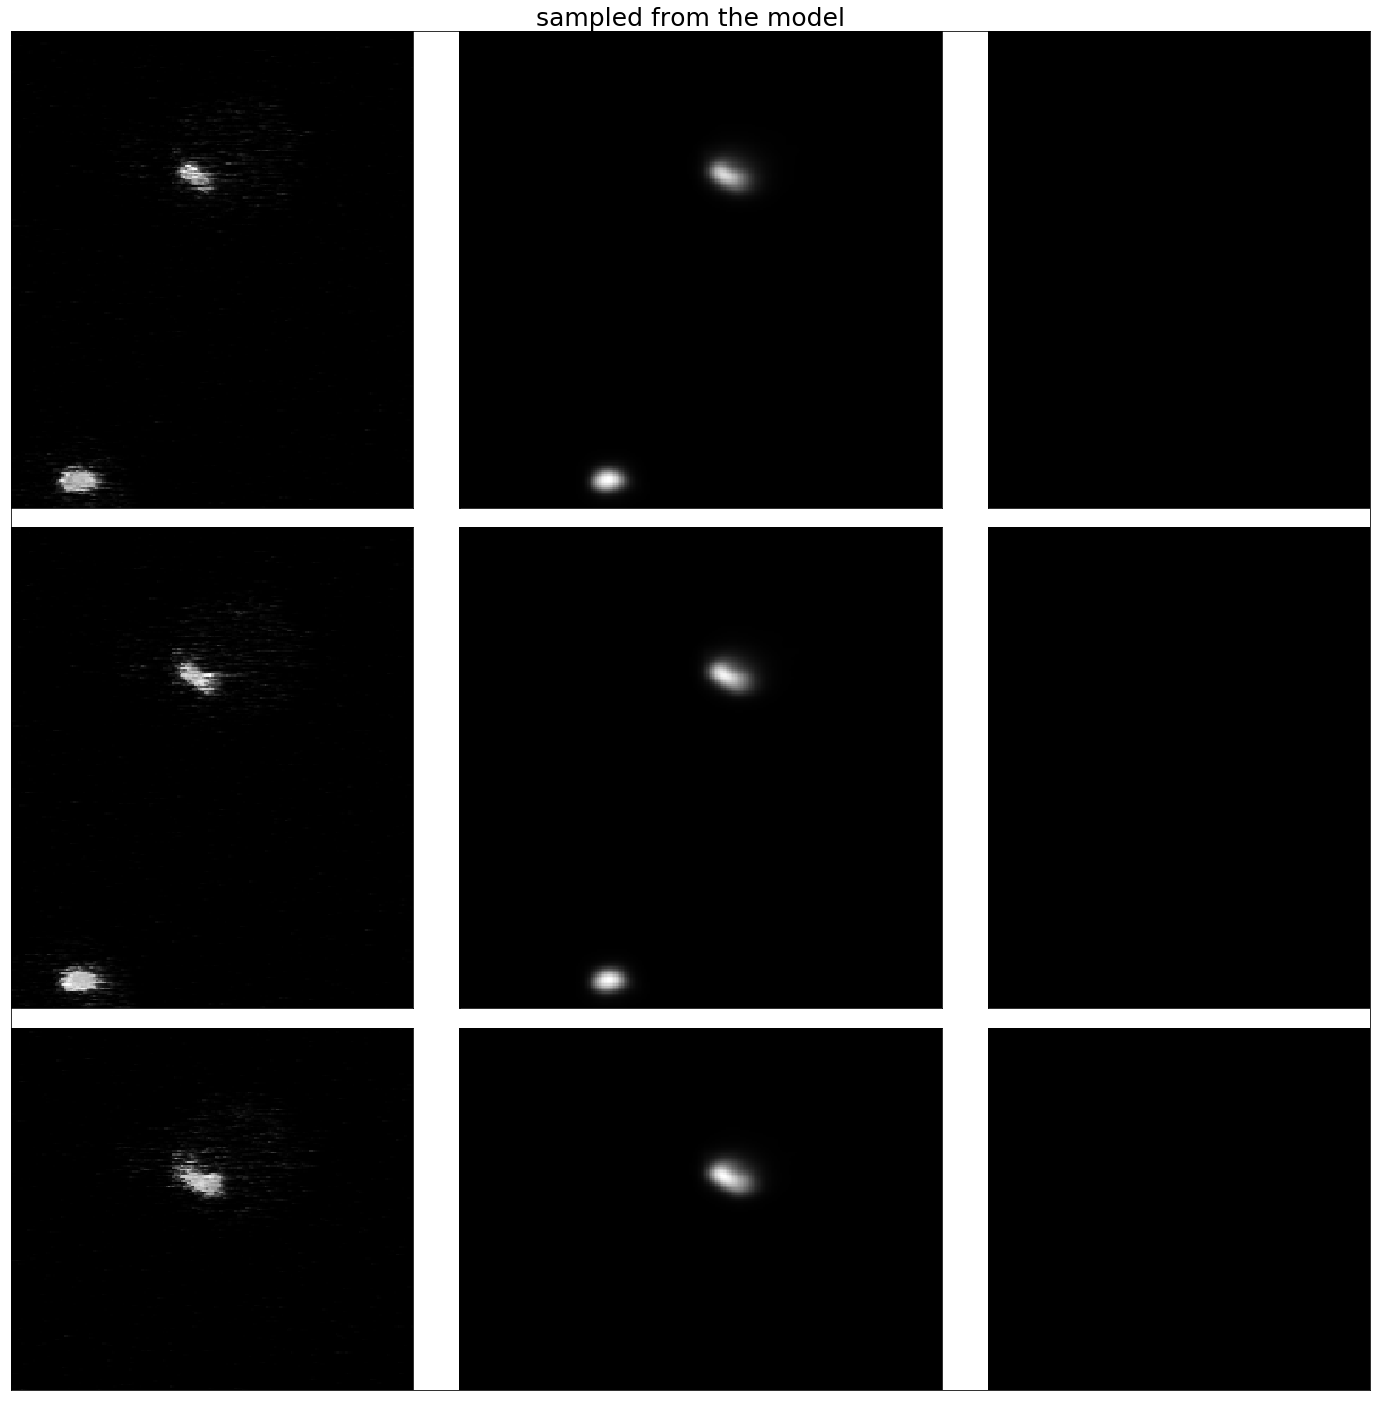

In [57]:
result_path = 'images/{0}/*'.format(dataset_name) 

model_vols = glob(result_path)
selected_folder = model_vols[-1]+'/*'

volumes = glob(selected_folder)
volumes = np.random.choice(volumes, size=1)[0]
vol_plot = io.imread(volumes)
cut = 120; ed = vol_plot.shape[0]
vol_plot = vol_plot[cut:ed-cut, cut:ed-cut , :]

print('plotted volume:', volumes)
f = plt.figure(figsize=(25,25))
plt.imshow(vol_plot); plt.xticks([]); plt.yticks([]); plt.title('sampled from the model', fontsize=25);

### save/load models, gradients and parameters

In [ ]:
save_models = False

if save_models:
    hp.model_saver(model_instance=gan.discriminator, model_name='disc_10%')
    hp.model_saver(model_instance=gan.generator, model_name='gene_10%')
    hp.model_saver(model_instance=gan.combined, model_name='combined_10%')

In [ ]:
load_models = False

if load_models:
    disc_json, disc = hp.model_loader('2018_8_1', '10_44_00_disc_10%')

# create deconvolution model

tf.fft_shift needs even number of dims, so eventually cut an array (then create new otf)

In [ ]:
print(vol.shape, otf.shape)
vol_new = vol[:,:,:8]
otf_new = PSF3D(im=vol_new.shape, ret_val = 'OTF')
print(vol_new.shape, otf_new.shape)

In [ ]:
# otf = PSF3D(im=vol.shape, ret_val = 'OTF')

deconvolution = deconv.Deconvolution_3D(img=vol_new, gan=gan_test, 
                                        psf=otf_new, simulation=False)

### perform deconvolution model

In [ ]:
deconvolution.optimize()

#  TEST

In [18]:
a = np.arange(1,10).reshape(3,3)
print(a)

np.pad(a, ((0,0),(0,2)), 'constant')

[[1 2 3]
 [4 5 6]
 [7 8 9]]


array([[1, 2, 3, 0, 0],
       [4, 5, 6, 0, 0],
       [7, 8, 9, 0, 0]])

In [95]:
e = np.around(np.random.uniform(low=0.7, high=1.2), decimals=1)

np.ones((3,3))*e

array([[1.1, 1.1, 1.1],
       [1.1, 1.1, 1.1],
       [1.1, 1.1, 1.1]])

In [14]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7155418596779636633, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6681632440
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3426702565545867077
 physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [ ]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant(3.0)
with tf.Session() as sess:
    print(sess.run(a))
        
# I believe that you need to set CUDA_VISIBLE_DEVICES=1. Or which ever GPU you want to use. 
#If you make only one GPU visible, you will refer to it as /gpu:0 regardless of what you set the environment variable to.
#More info on that environment variable: http://www.acceleware.com/blog/cudavisibledevices-masking-gpus

# https://stackoverflow.com/questions/40069883/how-to-set-specific-gpu-in-tensorflow

# if gpu > -1:
#     device = '/gpu:{}'.format(gpu)
# else:
#     device = '/cpu:0'

# with tf.device(device):
#     print('test')

In [ ]:
saver = tf.train.Saver(restore_sequentially=True)
saver_def = saver.as_saver_def()

In [ ]:
# a = tf.constant(vol_plot)
# b = deconvolution.total_variation(a)

vol_tf = tf.constant(vol_new)
otf_tf = tf.constant(otf_new)

conv = deconv.conv3d_fft_tf(vol=vol_tf, otf=otf_tf)

with tf.Session() as sess:
    vol_conv_tf = sess.run(conv)
    i = np.random.randint(low=0, high=vol_conv_tf.shape[2], size=1)[0]
    print('stack number:\t\t\t', i+1,'/',vol_conv_tf.shape[2])
    img_conv_tf = vol[:,:,i]
        
    plt.imshow(img_conv_tf, cmap='gray')       
    
# 296215300